In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import sys
warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth',100)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
df = pd.read_csv(r"C:\Users\nicka\OneDrive\Рабочий стол\all_data.csv",sep = ';',encoding = 'cp1251',index_col=0) #index_col=0 для того чтобы не было
df.sample(10)

author        author_type  \
8868                OPN PARTNER  real_estate_agent   
5203              DAVIDOV GROUP  real_estate_agent   
10629            АН Октябрьская  real_estate_agent   
9500                   ID 22653  real_estate_agent   
2321   Century 21 Street Realty  real_estate_agent   
6946         Point Estate Город  real_estate_agent   
2388                   RMRealty  real_estate_agent   
6118                   ID 25159            realtor   
3567                     i-deal  real_estate_agent   
4630                ID 99734301          homeowner   

                                                   link          city  \
8868     https://odintsovo.cian.ru/sale/flat/286206984/  Москва_и_др.   
5203   https://dzerzhinsky.cian.ru/sale/flat/287635524/  Москва_и_др.   
10629          https://www.cian.ru/sale/flat/287353360/  Москва_и_др.   
9500           https://www.cian.ru/sale/flat/287478786/  Москва_и_др.   
2321           https://www.cian.ru/sale/flat/280284659/  Москва_и_др.   
6946           https://www.cian.ru/sale/flat/279652018/  Москва_и_др.   
2388           https://www.cian.ru/sale/flat/284400552/  Москва_и_др.   
6118       https://vidnoye.cian.ru/sale/flat/287058201/  Москва_и_др.   
3567           https://www.cian.ru/sale/flat/280992021/  Москва_и_др.   
4630   https://krasnogorsk.cian.ru/sale/flat/287479527/  Москва_и_др.   

      deal_type accommodation_type  floor  floors_count  rooms_count  \
8868       sale               flat     10            26            2   
5203       sale               flat      6            18            1   
10629      sale               flat      3            14            4   
9500       sale               flat      1            16            3   
2321       sale               flat     12            13            4   
6946       sale               flat     11            18            4   
2388       sale               flat     24            27            4   
6118       sale               flat      2             3            1   
3567       sale               flat      9            15            5   
4630       sale               flat      5             8            1   

       total_meters  price_per_m2      price  year_of_construction  \
8868           58.0        189482   10990000                  2021   
5203           34.0        176470    6000000                  2004   
10629          75.5        211788   15990000                  1989   
9500           73.0        219178   16000000                  1975   
2321          185.0        864864  160000000                  2000   
6946          111.0        198198   22000000                  2018   
2388          168.0        386904   65000000                  2006   
6118           44.0        150000    6600000                  2017   
3567          141.0        602836   85000000                  2018   
4630           28.8        196180    5650000                  2017   

       living_meters  kitchen_meters        phone                   district  \
8868            33.0            11.0  79852073416                        NaN   
5203            20.0            10.0  79660625930                        NaN   
10629           52.3             8.3  79104875025           Ново-Переделкино   
9500            44.2            10.2  79660506490  Орехово-Борисово Северное   
2321            -1.0            -1.0  79197629005                      Арбат   
6946            88.0            -1.0  79852872196                        NaN   
2388            -1.0            -1.0  79852068469                     Щукино   
6118            15.0            16.0  79660514437                        NaN   
3567            74.6            15.7  79163412595                Хорошевский   
4630            21.0            -1.0  79663426096                        NaN   

                        street       underground residential_complex  
8868                       NaN          Сколково                 NaN  
5203                       NaN        К

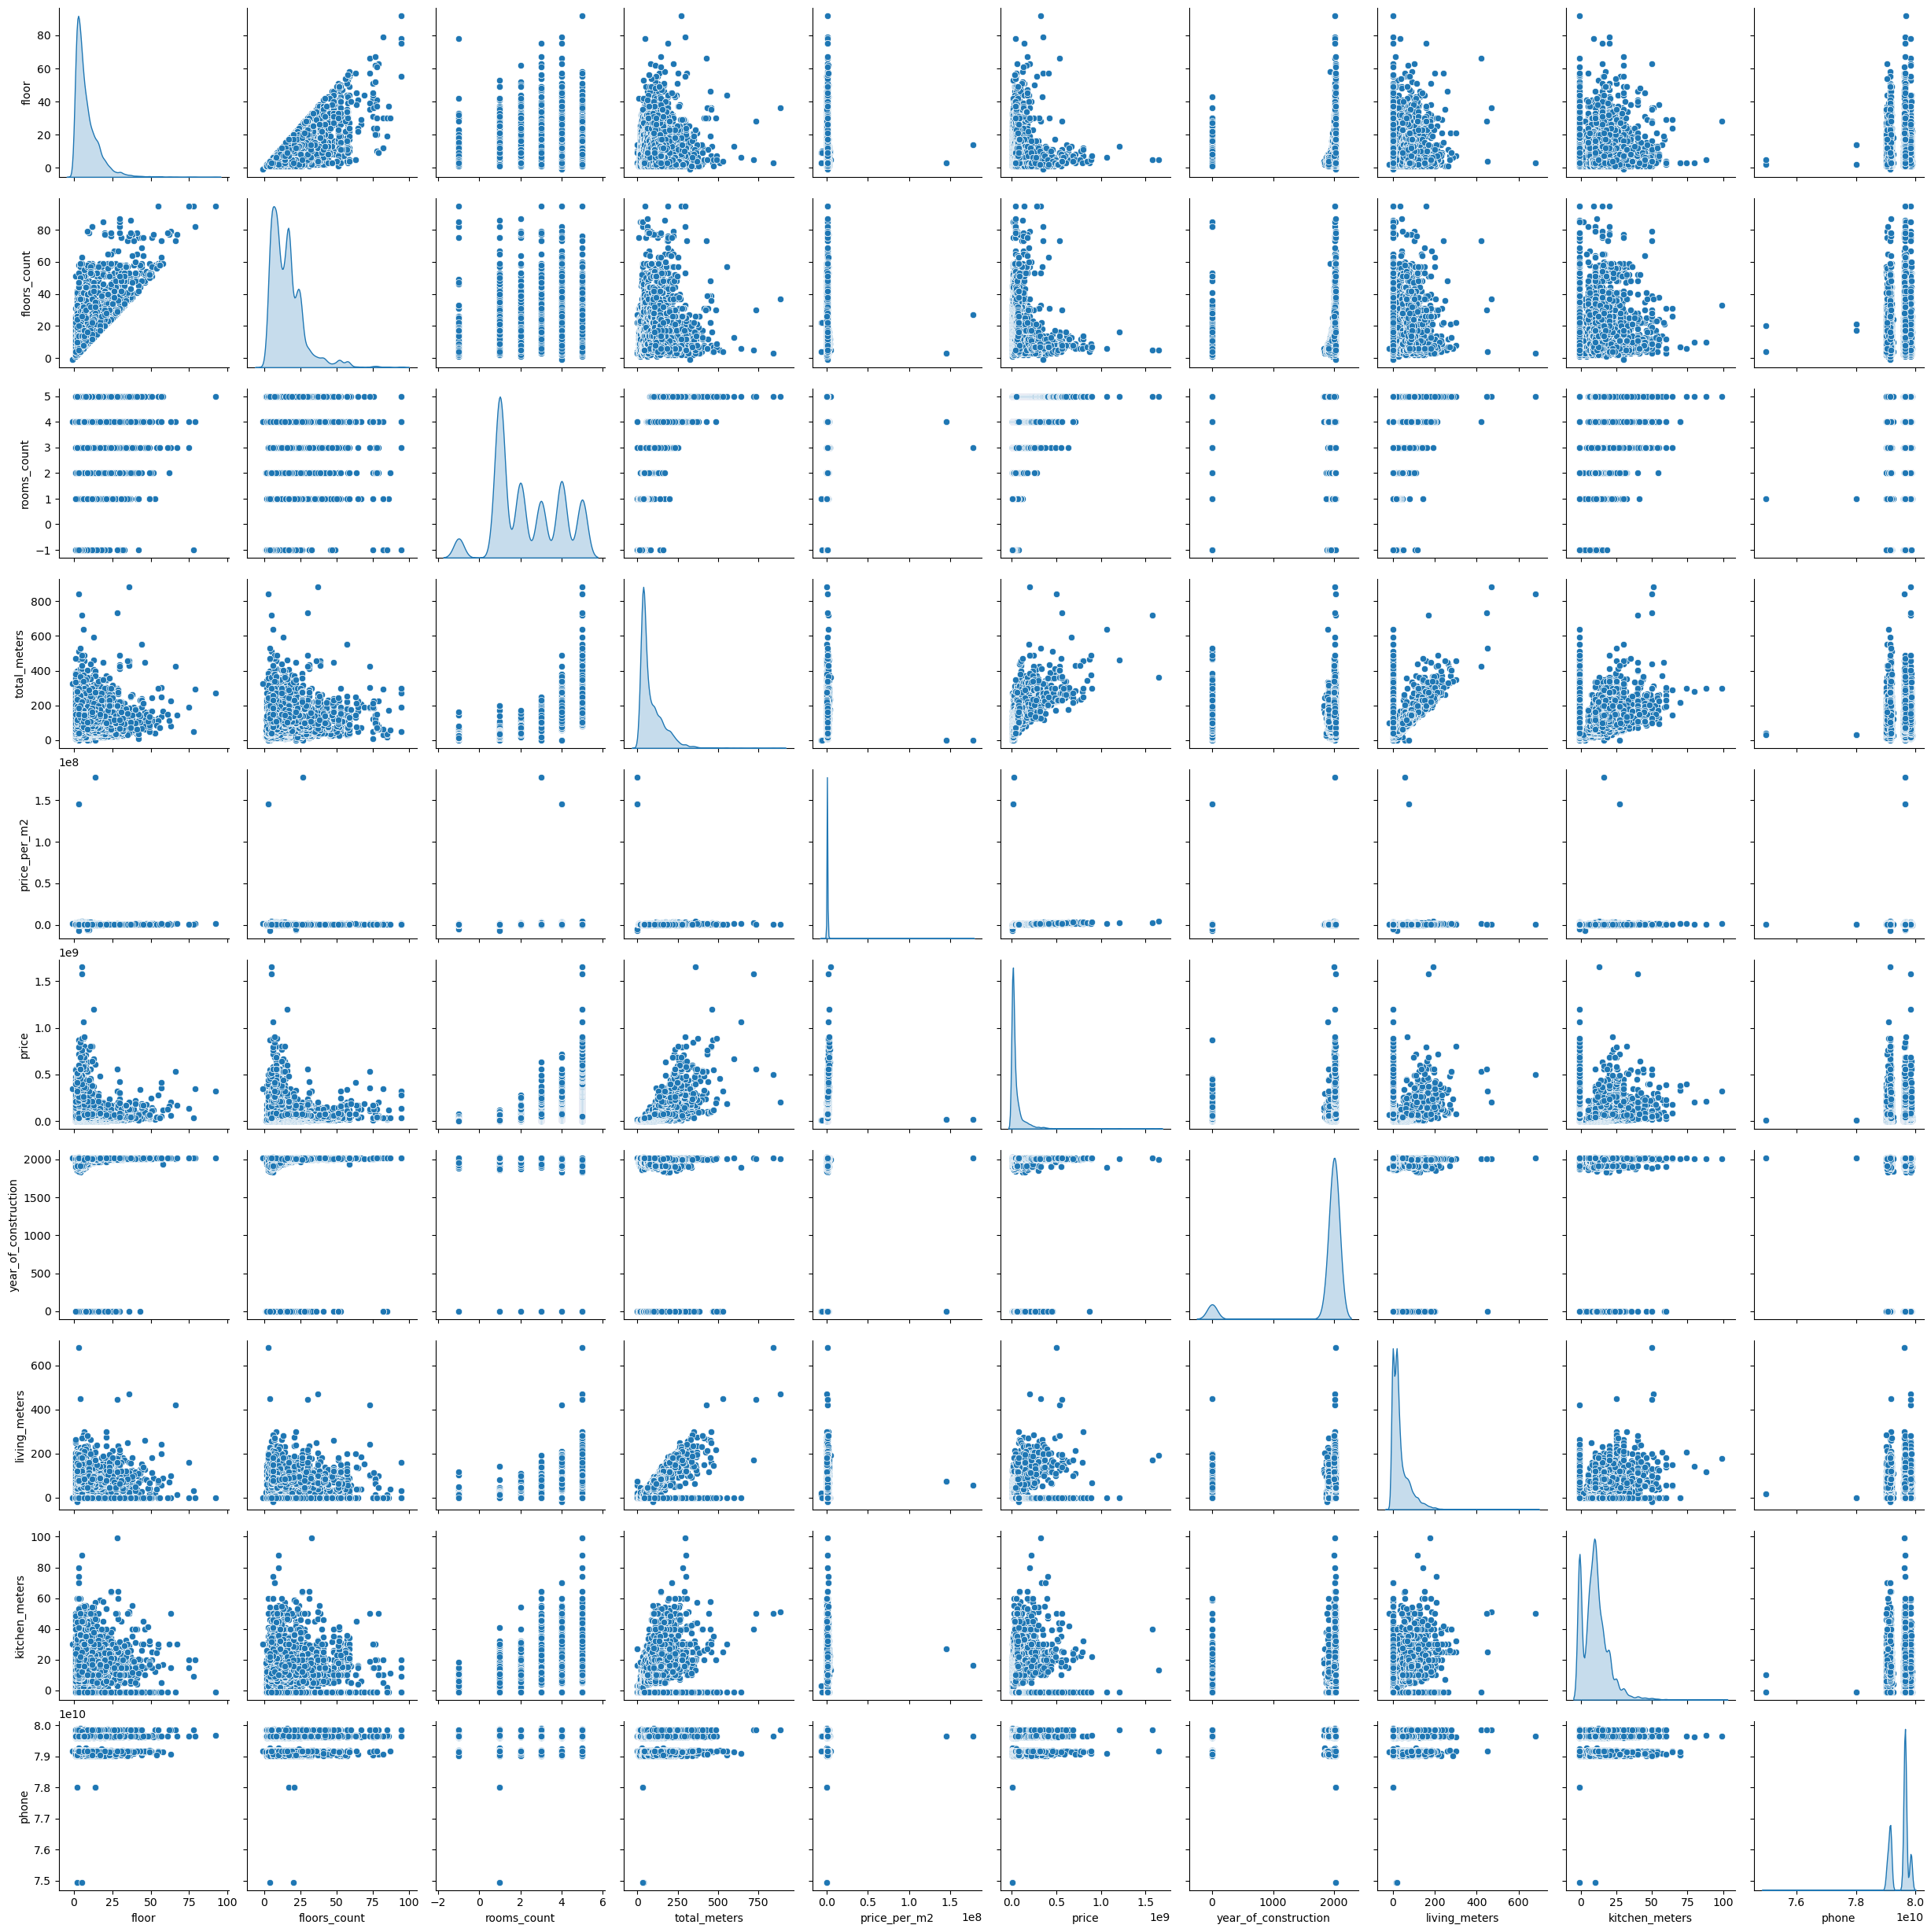

In [4]:
sns.pairplot(data=df, diag_kind='kde')

<Axes: >

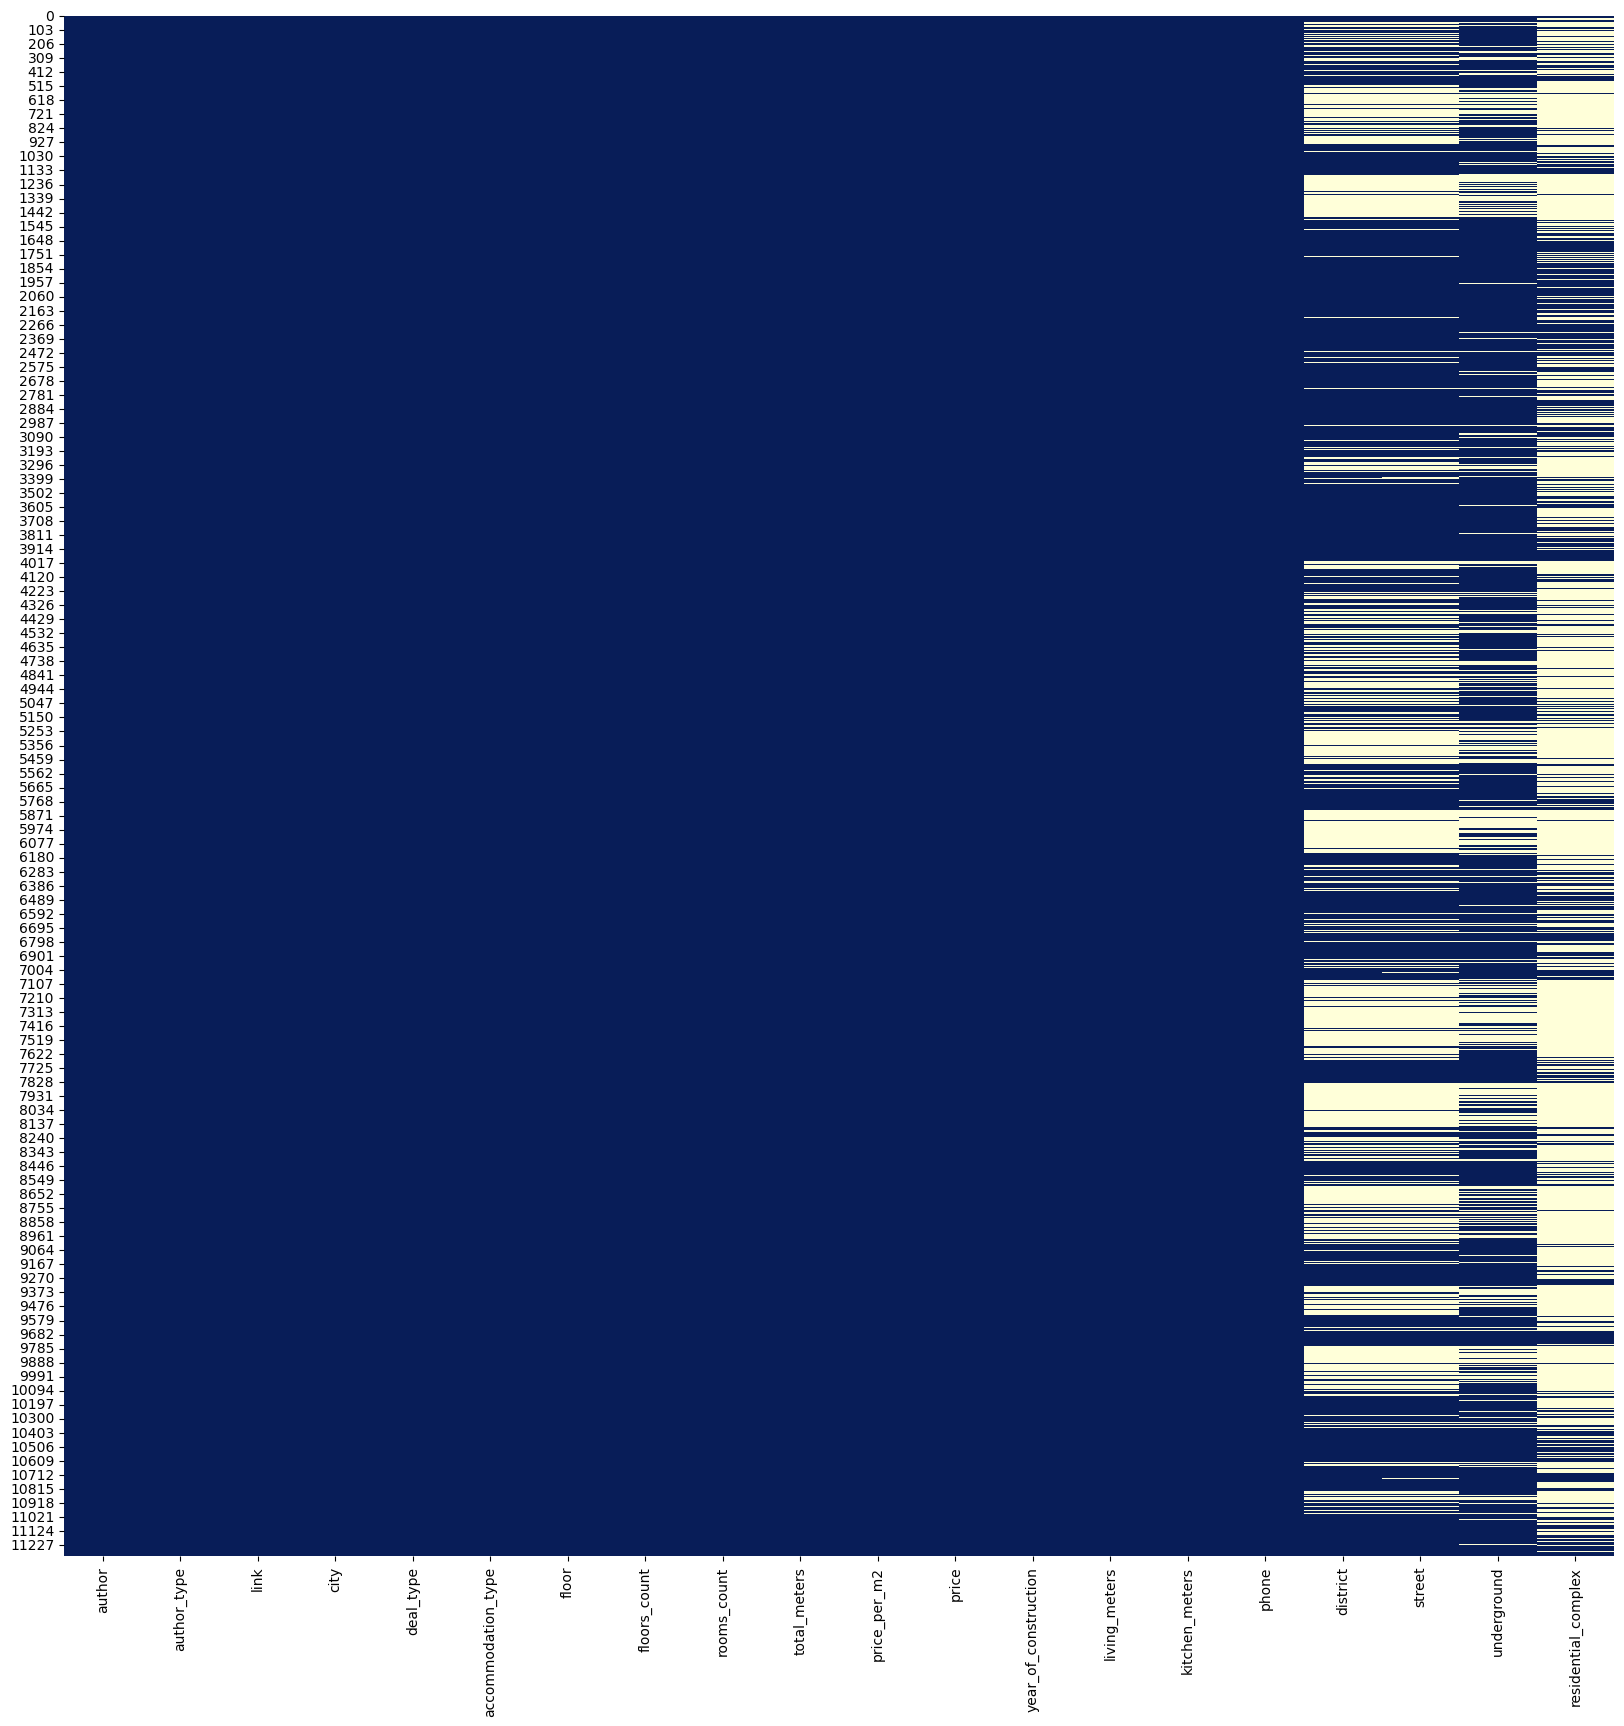

In [5]:
plt.figure(figsize = (20,20))
sns.heatmap(data = df.isnull(),cmap="YlGnBu_r",cbar=False)

In [6]:
df.isna().sum()/df.shape[0]*100

author                   0.035367
author_type              0.035367
link                     0.000000
city                     0.000000
deal_type                0.000000
accommodation_type       0.000000
floor                    0.000000
floors_count             0.000000
rooms_count              0.000000
total_meters             0.000000
price_per_m2             0.000000
price                    0.000000
year_of_construction     0.000000
living_meters            0.000000
kitchen_meters           0.000000
phone                    0.000000
district                36.118479
street                  36.251105
underground             21.786030
residential_complex     67.559682
dtype: float64

In [7]:
df.head(100)

author              author_type  \
0                 Константин Кудрявцев                  realtor   
1                  White and Broughton        real_estate_agent   
2                         Времена года        real_estate_agent   
3                  White and Broughton        real_estate_agent   
4                          ID 44396977                  realtor   
5                         Времена года        real_estate_agent   
6                                ИТКОЛ  official_representative   
7          Century 21 Premium Property        real_estate_agent   
8                          СТРОЙИНВЕСТ        real_estate_agent   
9                            Whitewill        real_estate_agent   
10   NF Group - ex-Knight Frank Russia        real_estate_agent   
11                    Эльвира Чижикова                  realtor   
12                         СТРОЙИНВЕСТ        real_estate_agent   
13                     Дарья Румянцева                  realtor   
14                         ID 18044580                  realtor   
15  ZAPAD REALTY - офис Маршала Жукова        real_estate_agent   
16                         ID 12564578                homeowner   
17                        ID 102136095                homeowner   
18                        Денис Каргин                  realtor   
19                         ID 18108810                  unknown   
20     Центр недвижимости от Сбербанка        real_estate_agent   
21                         Бест-Пресня        real_estate_agent   
22                         City Market        real_estate_agent   
23                       Kalinka Group        real_estate_agent   
24                   Кварта-ПИК БРОКЕР        real_estate_agent   
25                         СТРОЙИНВЕСТ        real_estate_agent   
26                      Наталья Тырина                  realtor   
27                         Бест-Пресня        real_estate_agent   
28                             Homeapp        real_estate_agent   
29                             Homeapp        real_estate_agent   
30                             Homeapp        real_estate_agent   
31                           ID 416302                  realtor   
32                         Бест-Пресня        real_estate_agent   
33                                 RED        real_estate_agent   
34                               Estes        real_estate_agent   
35                        ID 102091586                homeowner   
36                         СТРОЙИНВЕСТ        real_estate_agent   
37                          EstateLiga        real_estate_agent   
38            Century 21 Street Realty        real_estate_agent   
39            Century 21 Street Realty        real_estate_agent   
40                        ID 102646707                homeowner   
41                        СЕДЬМОЕ НЕБО        real_estate_agent   
42            Century 21 Street Realty        real_estate_agent   
43                           ЦеНтр ПИК        real_estate_agent   
44                         СТРОЙИНВЕСТ        real_estate_agent   
45                        СЕДЬМОЕ НЕБО        real_estate_agent   
46                         СТРОЙИНВЕСТ        real_estate_agent   
47                            ИМПЕРИАЛ  official_representative   
48                         ID 66610278                  realtor   
49                     PROНЕДВИЖИМОСТЬ        real_estate_agent   
50                        ID 102438676                homeowner   
51                          СЛУЖБА 925        real_estate_agent   
52                         OPN PARTNER        real_estate_agent   
53                     PROНЕДВИЖИМОСТЬ        real_estate_agent   
54                        ID 102633367                  realtor   
55                           PRO ОБМЕН        real_estate_agent   
56                          CENTURY 21        real_estate_agent   
57               Маленков недвижимость        real_estate_agent   
58                           ID 283823        real_estate_agent   
59          

In [8]:
df['link']

0        https://www.cian.ru/sale/flat/283849683/
1        https://www.cian.ru/sale/flat/280986757/
2        https://www.cian.ru/sale/flat/286530258/
3        https://www.cian.ru/sale/flat/283638079/
4        https://www.cian.ru/sale/flat/287127196/
                           ...                   
11305    https://www.cian.ru/sale/flat/287703757/
11306    https://www.cian.ru/sale/flat/284652097/
11307    https://www.cian.ru/sale/flat/284644852/
11308    https://www.cian.ru/sale/flat/285604501/
11309    https://www.cian.ru/sale/flat/282401854/
Name: link, Length: 11310, dtype: object

In [9]:
df.shape

(11310, 20)

In [10]:
df = df.drop_duplicates()
df.shape

(8391, 20)

In [11]:
df_cop = df.copy()

# Вычисление ненужных данных

### City

In [12]:
df_cop['city'].unique()

array(['Москва_и_др.'], dtype=object)

In [13]:
df_cop.drop(columns = 'city',inplace = True)

### Ссылка на квартиры нам не понадобиться кроме (!!!!!) того как если бы мы показывали похожие квартиры

In [14]:
df_cop.drop(columns = 'link',inplace = True)

### Deal_type

In [15]:
df_cop['deal_type'].unique()

array(['sale'], dtype=object)

In [16]:
df_cop.drop(columns = 'deal_type',inplace = True)

### Accommodation_type

In [17]:
df_cop['accommodation_type'].unique()

array(['flat'], dtype=object)

In [18]:
df_cop.drop(columns = 'accommodation_type',inplace = True)

### Телефон для нашей модели также не нужен т.к. это индивидуальная информация

In [19]:
df_cop.drop(columns = 'phone',inplace = True)

### Author и Author_type пользователь знать не сможет, т.к. мы просто будем оценивать квартиру

In [20]:
df_cop.drop(columns = ['author','author_type'],inplace = True)

In [21]:
df_cop.sample(20)

floor  floors_count  rooms_count  total_meters  price_per_m2      price  \
2021      3             7            4        174.00       1787356  311000000   
3329     12            21            5        200.00        166950   33390000   
2419      4            21            4        150.00        439333   65900000   
9325      7            10            3        124.00       2000000  248000000   
1641     13            41            3         67.00        701492   47000000   
1486      2             9            2         37.60        239361    8999999   
2821      7            14            5        292.12       2200000  642664000   
1938     30            41            4        145.60        535638   77989000   
6497      9             9            3         51.20        214843   11000000   
778      16            25            1         36.40        206043    7500000   
8331     16            23            2         60.00        151666    9100000   
7217      2             3           -1         13.70        269343    3690000   
760      19            25            1         44.00        162500    7150000   
1015     10            20            1         38.70        335917   13000000   
7259      3             9            1         21.80        172018    3750000   
4422     16            25            1         27.60        380434   10500000   
3472      2            22            5        165.00        393939   65000000   
7309      1             3            1         26.00        150000    3900000   
6458      6            12            3        121.00        553719   67000000   
8189      7            15            2         59.90        450751   27000000   

      year_of_construction  living_meters  kitchen_meters  \
2021                  2015           -1.0            -1.0   
3329                  2011          120.0            30.0   
2419                  2003          100.0            20.0   
9325                  2019           66.0            18.0   
1641                  2021           -1.0            -1.0   
1486                  1966           22.8             7.0   
2821                  2021           -1.0            -1.0   
1938                  2021           -1.0            -1.0   
6497                  1975           33.7             6.2   
778                   2020           20.0             7.5   
8331                  2016           31.7            16.0   
7217                    -1           -1.0            -1.0   
760                   2019           18.0            12.0   
1015                  2021           15.0            12.4   
7259                  2019           12.6             3.0   
4422                  2022           -1.0            -1.0   
3472                  2003           -1.0            20.0   
7309                  2014           15.0             6.0   
6458                  2004           70.2            15.4   
8189                  1974           31.6             8.0   

                       district                   street  \
2021                  Хамовники                 Ефремова   
3329                        NaN                      NaN   
2419              Ломоносовский       Академика Пилюгина   
9325                  Мещанский      Звонарский переулок   
1641                Хорошевский   Ленинградский проспект   
1486                  Гольяново         Щелковское шоссе   
2821                  Хамовники  переулок 1-й Тружеников   
1938                Хорошевский   Ленинградский проспект   
6497  Орехово-Борисово Северное         Маршала Захарова   
778                         NaN                      NaN   
8331                        NaN                      NaN   
7217              Нижегородский             шоссе Фрезер   
760                         NaN                      NaN   
1015               Алексеевский         Новоалексеевская   
7259                        NaN                      NaN   
4422                     Щукино                Берзарина   
34

Соединяем колонки с адресами и в общем местоположением т.к. в них большое количество пропусков, а информация в них весьма полезна для предсказаний нашей модели

In [22]:
df_cop['address'] = df_cop['district'].fillna('') + ' ' + df_cop['street'].fillna('') + ' ' + df_cop['underground'].fillna('') + \
                    ' ' + df_cop['residential_complex'].fillna('')

In [23]:
df_cop.sample(100)

floor  floors_count  rooms_count  total_meters  price_per_m2  \
893       16            17            1         35.00        265714   
3445       5             5            5        120.00        481416   
3014       4            12            5        328.60       1097837   
2190      15            19            4         95.00        589473   
6532       3            15            3         86.80        190092   
160        1             8            1         40.50        164197   
1138       6             9            1         55.00        500000   
4634       8            14            1         24.80        147177   
1126       8            38            1         49.00        487755   
1574       7            17            2         63.40        209779   
6315       6            18            2         66.50        481203   
3703       5             6            5        126.40       1066630   
1550       4             5            2         38.10        144000   
11094      4            59            4        130.00        584615   
7103       1             4            1         22.00        136363   
1146       3             5            1         42.00        833333   
7355       4             6            1         26.10        153500   
10558      5             8            4        184.60       1191765   
1421      13            14            1         37.30        171581   
3727       3            10            5        206.00        721498   
2018      11            13            4        171.00        847953   
9345       2             4            3         56.00        133928   
9565       3             5            3         80.90        249690   
8615       2             4            2         46.25        104864   
1100       2            10            1         35.00        551428   
2140      15            24            4        147.00        564285   
4044      12            13            5        144.00        156250   
3353      15            17            5        122.40        282679   
4921       3             9            1         16.00        400000   
1849       2             9            3        119.00        991596   
8201       6            12            2         47.50        260421   
9312       3             9            3        180.00       1000138   
689        2             5            1         16.00        371875   
1521      15            17            2         56.50        235398   
9411      15            17            3         76.50        154248   
3478      11            13            5        232.50        279569   
4577       7            10           -1         14.00        414285   
2349      18            25            4         98.00        661224   
8487       5            10            2         58.00        344827   
4086      19            19            5        128.30        272798   
9481       5            16            3         90.00        168888   
8245      11            16            2         55.00        327272   
10885      1            12            4         75.30        250996   
9332       2             5            3         55.70        101436   
6625      23            23            3         86.00        174302   
6289      34            36            2         69.00        500000   
3444      27            34            5        150.00        386666   
4265       1             3           -1         17.60        320000   
3950       2            12            5        304.00       1266085   
7450       8             9            1         23.00        184782   
11029      8            17            4        116.00        448275   
6210      14            16            2         60.00        243333   
529        2            20            1         38.75        211612   
10483     10            17            4        203.50        638820   
8765       8            17            2         53.40        168539   
8244       2            17     

In [24]:
df_cop[df_cop['address'] == '   ']

floor  floors_count  rooms_count  total_meters  price_per_m2     price  \
30         6             6            1          36.6        133879   4900000   
44        12            17            1          37.1        142773   5296910   
46         2            17            1          37.0        153062   5663320   
51        10            26            1          39.0        243589   9500000   
52         5             9            1          31.0        160967   4990000   
...      ...           ...          ...           ...           ...       ...   
10972      4             9            4         143.0        272727  39000000   
10996      7             8            4         138.0        326086  45000000   
11005      3             6            4         230.0        208695  48000000   
11042      2             6            4         196.0        280612  55000000   
11067      1             4            4         148.0        411824  60950000   

       year_of_construction  living_meters  kitchen_meters district street  \
30                       -1           14.5             9.5      NaN    NaN   
44                     2022           13.8            11.9      NaN    NaN   
46                     2022           14.0            13.5      NaN    NaN   
51                     2017           18.0            12.0      NaN    NaN   
52                     2022           -1.0            -1.0      NaN    NaN   
...                     ...            ...             ...      ...    ...   
10972                  2017           65.2            14.4      NaN    NaN   
10996                  2016           -1.0            -1.0      NaN    NaN   
11005                    -1          150.0            60.0      NaN    NaN   
11042                    -1          120.9            27.0      NaN    NaN   
11067                    -1           -1.0            24.0      NaN    NaN   

      underground residential_complex address  
30            NaN                 NaN          
44            NaN                 NaN          
46            NaN                 NaN          
51            NaN                 NaN          
52            NaN                 NaN          
...           ...                 ...     ...  
10972         NaN                 NaN          
10996         NaN                 NaN          
11005         NaN                 NaN          
11042         NaN                 NaN          
11067         NaN                 NaN          

[1461 rows x 14 columns]

In [25]:
df_cop.drop(df_cop[df_cop['address'] == '   '].index,inplace = True)

И удаляем уже ненужные спаршенные колонки из датасета

In [26]:
df_cop.drop(columns = ['district','street','underground','residential_complex'],inplace = True)

In [27]:
df_cop.sample(100)

floor  floors_count  rooms_count  total_meters  price_per_m2  \
2040       3            24            4        113.40        458553   
6196       5            20            2         43.00        837209   
3691       6             8            5        235.00        553191   
6405      44            59            2         66.00        431818   
3963       2             3            5        314.50       1401957   
4241       6             6           -1         15.70        230853   
2438       9            10            4        113.00        252212   
20         8            16            1         37.90        285224   
8197      20            24            2         55.80        443548   
1960      10            19            4        135.00        333333   
2          5            14            1         61.97        919799   
9166      21            23            3         92.00        271630   
6277       2             7            2         60.40        739457   
7263       3            14            1         23.22        163652   
537       16            31            1         41.00        534146   
6613       4            16            3         80.00        537500   
4887      11            16            1         20.00        300000   
2888       4            13            5        200.10        899500   
8707      16            22            2         42.00        185714   
1886       2             9            4        109.00       1191743   
923       15            16            1         36.00        277777   
2719       3             6            5        175.00        657142   
2255      28            32            4        161.30        427774   
10926      4             5            4         84.90        329799   
10711      5             6            4        151.60        303430   
470        9            18            1         44.10        453287   
3387       5            15            5        121.00        355371   
2148       3            17            4         93.00        225806   
2497      12            30            4        138.00        369565   
8209       3             5            2         43.60        286674   
2231      16            18            4        220.00        909090   
4200       8            46           -1         30.00        450000   
2443       9            10            4        104.00        172884   
4341      12            33            1         20.70        425120   
1078       9            28            1         40.60        413790   
4802       4            17            1         24.50        167346   
7212       2             5           -1         18.00        200000   
9601      16            17            3         77.20        317357   
5066       1             4           -1         22.00        431818   
6276       9            12            2         39.20        333928   
2114       9            12            4        101.10        672601   
526        2             5            1         16.70        365269   
3656      27            31            5        212.00        537735   
2477      18            31            4        145.00        365517   
908        4            18            1         35.00        277142   
8708       2             9            2         44.50        175280   
491       19            23            1         41.00        502439   
585        2             5            1         19.80        247474   
7441      18            24            1         26.32        162613   
333        5            23            1         34.20        251461   
9228       4            14            3        118.00        411016   
8957       8             9            2         36.90        348238   
7308      10            17            1         25.70        151750   
3067      10            14            5        201.92        881537   
1151       2            16            1         49.00        795918   
8531      18            24     

<Axes: >

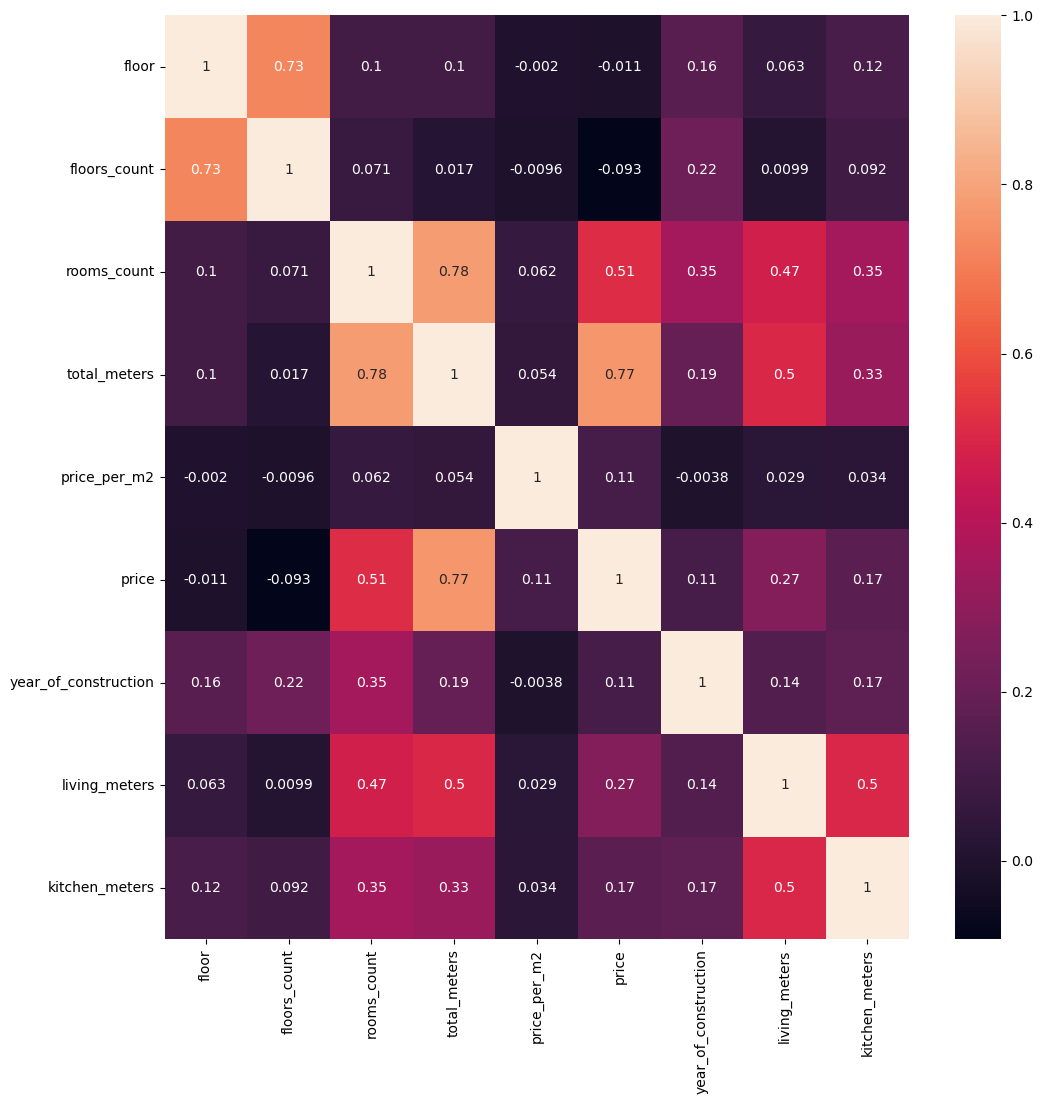

In [28]:
plt.figure(figsize = (12,12))
sns.heatmap(df_cop.drop(columns = 'address').corr(),annot = True)

In [29]:
df_cop['address']

0                                         Текстильщики Шкулева Волжская 
1                 Хорошевский Ленинградский проспект Аэропорт Прайм Парк
2                          Хамовники Усачева Спортивная Садовые кварталы
3                 Хорошевский Ленинградский проспект Аэропорт Прайм Парк
4                 Нагатино-Садовники Нагатинская набережная Коломенская 
                                      ...                               
11150                               Обручевский Островитянова Тропарёво 
11287                  Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
11303    Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
11304      Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse
11309                     Пресненский Мантулинская Выставочная City Park
Name: address, Length: 6930, dtype: object

Смотрим на nan значения

<Axes: >

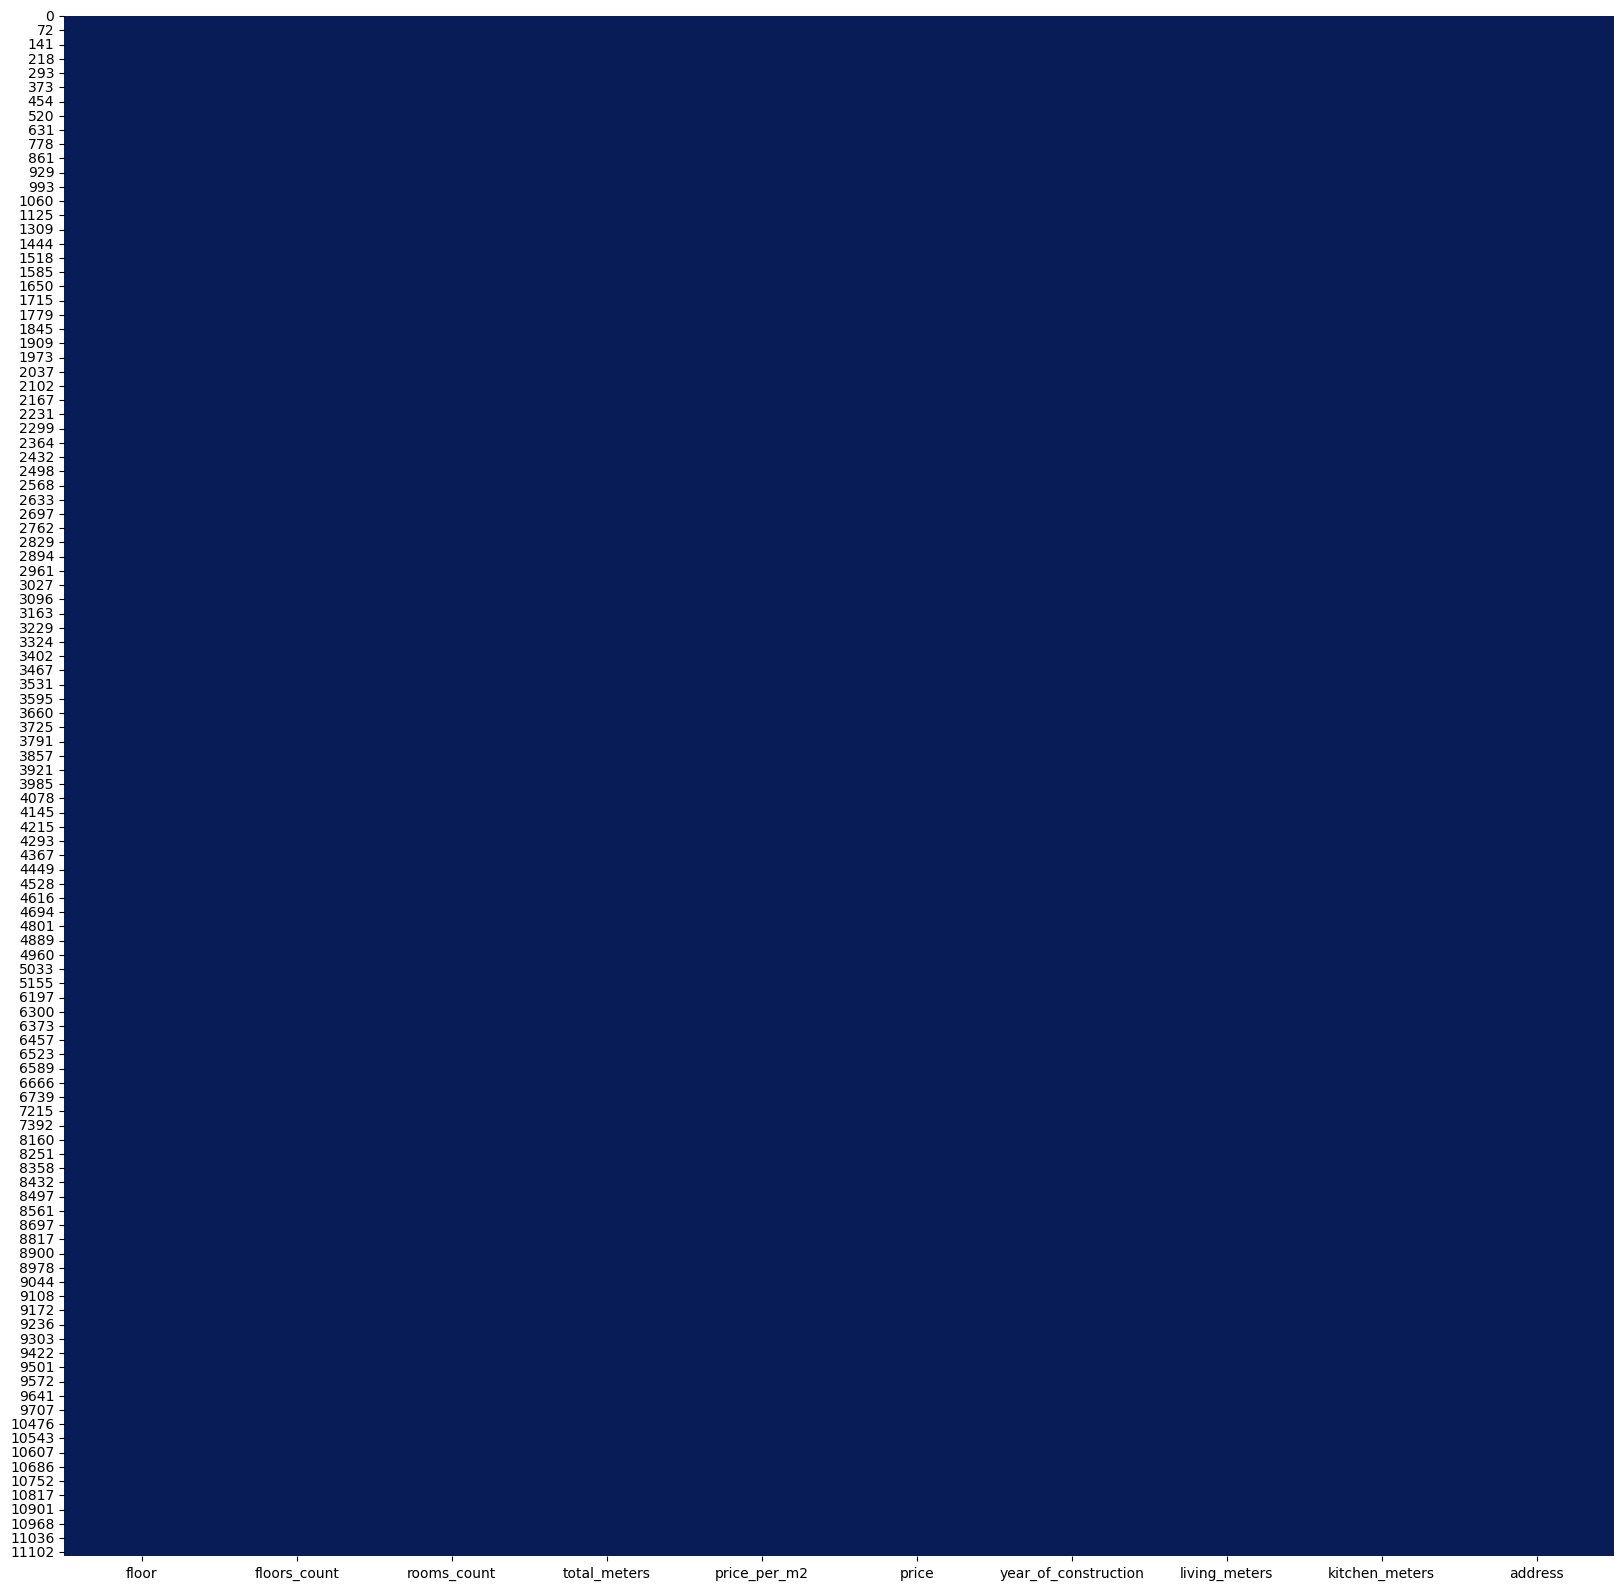

In [30]:
plt.figure(figsize = (20,20))
sns.heatmap(data = df_cop.isnull(),cmap="YlGnBu_r",cbar=False)

In [31]:
df_cop.isna().sum()/df.shape[0]*100

floor                   0.0
floors_count            0.0
rooms_count             0.0
total_meters            0.0
price_per_m2            0.0
price                   0.0
year_of_construction    0.0
living_meters           0.0
kitchen_meters          0.0
address                 0.0
dtype: float64

In [32]:
df_cop.dropna(inplace = True)
df_cop.reset_index(drop = True,inplace = True)
df_cop.head(100)

floor  floors_count  rooms_count  total_meters  price_per_m2     price  \
0       1             5            1         12.00        291666   3500000   
1      17            41            1         40.40        618811  25000000   
2       5            14            1         61.97        919799  57000000   
3       9            41            1         40.50        617283  25000000   
4      12            17            1         47.60        324579  15450000   
5       6            13            1         71.10        983122  69900000   
6       7             9            1         18.00        382000   6876000   
7      33            36            1         75.00        626666  47000000   
8       9            17            1         37.20        147072   5471080   
9       6            41            1         41.00        724390  29700000   
10     16            21            1         48.00        602708  28930000   
11      5             9            1         32.00        404687  12950000   
12     15            21            1         46.40        256465  11900000   
13     12            26            1         42.00        402380  16900000   
14     18            18            1         34.00        300000  10200000   
15     24            24            1         32.00        650000  20800000   
16      9             9            1         31.20        365384  11400000   
17      2             9            1         33.00        275757   9100000   
18      1             3            1         22.10        223981   4949999   
19     15            15            1         38.30        275456  10550000   
20      8            16            1         37.90        285224  10810000   
21      2            25            1         38.00        175000   6650000   
22     34            52            1         42.20        425355  17950000   
23     18            22            1         46.00        652173  30000000   
24      6            16            1         36.20        215359   7796000   
25     21            26            1         36.90        207317   7650000   
26      1             2            1         15.11        330906   4999999   
27      9            12            1         36.00        238888   8600000   
28      1            12            1         39.10        237851   9300000   
29     14            26            1         32.50        267692   8700000   
30      2            14            1         45.20        519911  23500000   
31     14            17            1         33.50        191044   6400000   
32      4            27            1         47.40        411392  19500000   
33      4            29            1         45.00        511111  23000000   
34     17            17            1         38.00        297368  11300000   
35     13            25            1         41.50        224002   9296100   
36     53            58            1         38.50        415584  16000000   
37     20            58            1         37.50        554666  20800000   
38     27            48            1         29.00        565517  16400000   
39      2             6            1         52.20        295019  15400000   
40     22            30            1         37.00        500000  18500000   
41     25            58            1         31.10        549839  17100000   
42     17            21            1         32.80        442073  14500000   
43     22            58            1         40.00        495000  19800000   
44      3             5            1         19.70        375634   7400000   
45      6            16            1         29.20        527397  15400000   
46     13            19            1         43.00        208139   8950000   
47      5            25            1         40.00        237500   9500000   
48     12            17            1         38.00        214473   8150000   
49     12            12            1         32.90        243161   8000000   
50     14            15   

In [33]:
df_cop

floor  floors_count  rooms_count  total_meters  price_per_m2     price  \
0         1             5            1         12.00        291666   3500000   
1        17            41            1         40.40        618811  25000000   
2         5            14            1         61.97        919799  57000000   
3         9            41            1         40.50        617283  25000000   
4        12            17            1         47.60        324579  15450000   
...     ...           ...          ...           ...           ...       ...   
6925     11            22            4        119.40        293132  35000000   
6926     11            17            4        172.63        434455  74999999   
6927     37            78            2         73.00        602739  44000000   
6928      3             5            2         42.00        892142  37470000   
6929      9            16            3        105.00        694761  72950000   

      year_of_construction  living_meters  kitchen_meters  \
0                       -1           -1.0            -1.0   
1                     2021           15.2             9.1   
2                     2022           -1.0            -1.0   
3                     2022           17.3             9.3   
4                     2019           -1.0            10.0   
...                    ...            ...             ...   
6925                  2004           67.3            17.8   
6926                  2008           -1.0            -1.0   
6927                  2020           -1.0            -1.0   
6928                  2021           -1.0            -1.0   
6929                  2020           -1.0            -1.0   

                                                              address  
0                                      Текстильщики Шкулева Волжская   
1              Хорошевский Ленинградский проспект Аэропорт Прайм Парк  
2                       Хамовники Усачева Спортивная Садовые кварталы  
3              Хорошевский Ленинградский проспект Аэропорт Прайм Парк  
4              Нагатино-Садовники Нагатинская набережная Коломенская   
...                                                               ...  
6925                             Обручевский Островитянова Тропарёво   
6926                Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк  
6927  Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS  
6928    Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse  
6929                   Пресненский Мантулинская Выставочная City Park  

[6930 rows x 10 columns]

In [34]:
print('floor')
print(np.sort(df_cop['floor'].unique()))
print('floors_count')
print(np.sort(df_cop['floors_count'].unique()))
print('rooms_count')
print(np.sort(df_cop['rooms_count'].unique()))
print('total_meters')
print(np.sort(df_cop['total_meters'].unique()))
print('price_per_m2')
print(np.sort(df_cop['price_per_m2'].unique()))
print('year_of_construction')
print(np.sort(df_cop['year_of_construction'].unique()))
print('living_meters')
print(np.sort(df_cop['living_meters'].unique()))
print('kitchen_meters')
print(np.sort(df_cop['kitchen_meters'].unique()))

floor
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 61 62 63 66 67 75 78 79 92]
floors_count
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 63 64 65 67 69 73 75 76 77 78 79
 82 85 86 87 95]
rooms_count
[-1  1  2  3  4  5]
total_meters
[-1.0000e+00  1.0100e-01  1.2000e-01  7.5000e+00  8.7000e+00  1.0000e+01
  1.0300e+01  1.0400e+01  1.0500e+01  1.0600e+01  1.1000e+01  1.1100e+01
  1.1400e+01  1.1500e+01  1.1600e+01  1.1700e+01  1.1800e+01  1.1900e+01
  1.2000e+01  1.2100e+01  1.2300e+01  1.2400e+01  1.2500e+01  1.2600e+01
  1.2700e+01  1.2800e+01  1.3000e+01  1.3100e+01  1.3300e+01  1.3400e+01
  1.3500e+01  1.3600e+01  1.3700e+01  1.3800e+01  1.3900e+01  1.4000e+01
  1.4100e+01  1.4200e+01  1.4300e+01  1.4400e+01  1.45

# Выбросы

In [35]:
def quantiles(arr):
    work_val = arr.copy()
    Q1 = work_val.quantile(0.25)#np.percentile(work_val, 25, method= 'midpoint')
    Q3 = work_val.quantile(0.75)#np.percentile(work_val, 75, method= 'midpoint')
    IQR = Q3-Q1
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR
    return upper,lower

def anti_emmi(df):
    if df.select_dtypes(include = [np.number]).all().any():
        for col in df.select_dtypes(include = [np.number]).columns:
            
            up,low = quantiles(df[col])
            df = df[~(df[col] < low) | (df[col] > up)]

    return df.reset_index(drop=True)

In [36]:
df_cop = anti_emmi(df_cop)
df_cop

floor  floors_count  rooms_count  total_meters  price_per_m2     price  \
0        17            41            1         40.40        618811  25000000   
1         5            14            1         61.97        919799  57000000   
2         9            41            1         40.50        617283  25000000   
3        12            17            1         47.60        324579  15450000   
4         6            13            1         71.10        983122  69900000   
...     ...           ...          ...           ...           ...       ...   
6230     11            22            4        119.40        293132  35000000   
6231     11            17            4        172.63        434455  74999999   
6232     37            78            2         73.00        602739  44000000   
6233      3             5            2         42.00        892142  37470000   
6234      9            16            3        105.00        694761  72950000   

      year_of_construction  living_meters  kitchen_meters  \
0                     2021           15.2             9.1   
1                     2022           -1.0            -1.0   
2                     2022           17.3             9.3   
3                     2019           -1.0            10.0   
4                     2019           37.1            12.8   
...                    ...            ...             ...   
6230                  2004           67.3            17.8   
6231                  2008           -1.0            -1.0   
6232                  2020           -1.0            -1.0   
6233                  2021           -1.0            -1.0   
6234                  2020           -1.0            -1.0   

                                                              address  
0              Хорошевский Ленинградский проспект Аэропорт Прайм Парк  
1                       Хамовники Усачева Спортивная Садовые кварталы  
2              Хорошевский Ленинградский проспект Аэропорт Прайм Парк  
3              Нагатино-Садовники Нагатинская набережная Коломенская   
4                       Хамовники Усачева Спортивная Садовые кварталы  
...                                                               ...  
6230                             Обручевский Островитянова Тропарёво   
6231                Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк  
6232  Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS  
6233    Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse  
6234                   Пресненский Мантулинская Выставочная City Park  

[6235 rows x 10 columns]

In [37]:
df_cop.columns

Index(['floor', 'floors_count', 'rooms_count', 'total_meters', 'price_per_m2',
       'price', 'year_of_construction', 'living_meters', 'kitchen_meters',
       'address'],
      dtype='object')

In [38]:
for col in df_cop.drop(columns = 'address').columns:
    print(col)
    print(df_cop[df_cop[col]<0][col].unique())

floor
[-1]
floors_count
[-1]
rooms_count
[-1]
total_meters
[]
price_per_m2
[]
price
[]
year_of_construction
[]
living_meters
[-1.]
kitchen_meters
[-1.]


Если значение = -1 (тоесть отсутствует) оно заменяется на среднее по колонке

In [39]:
# for col in df_cop.drop(columns = ['address','year_of_construction']).columns:
#     df_cop = df_cop.drop(df_cop[df_cop[col] == -1].index)

In [40]:
df_cop

floor  floors_count  rooms_count  total_meters  price_per_m2     price  \
0        17            41            1         40.40        618811  25000000   
1         5            14            1         61.97        919799  57000000   
2         9            41            1         40.50        617283  25000000   
3        12            17            1         47.60        324579  15450000   
4         6            13            1         71.10        983122  69900000   
...     ...           ...          ...           ...           ...       ...   
6230     11            22            4        119.40        293132  35000000   
6231     11            17            4        172.63        434455  74999999   
6232     37            78            2         73.00        602739  44000000   
6233      3             5            2         42.00        892142  37470000   
6234      9            16            3        105.00        694761  72950000   

      year_of_construction  living_meters  kitchen_meters  \
0                     2021           15.2             9.1   
1                     2022           -1.0            -1.0   
2                     2022           17.3             9.3   
3                     2019           -1.0            10.0   
4                     2019           37.1            12.8   
...                    ...            ...             ...   
6230                  2004           67.3            17.8   
6231                  2008           -1.0            -1.0   
6232                  2020           -1.0            -1.0   
6233                  2021           -1.0            -1.0   
6234                  2020           -1.0            -1.0   

                                                              address  
0              Хорошевский Ленинградский проспект Аэропорт Прайм Парк  
1                       Хамовники Усачева Спортивная Садовые кварталы  
2              Хорошевский Ленинградский проспект Аэропорт Прайм Парк  
3              Нагатино-Садовники Нагатинская набережная Коломенская   
4                       Хамовники Усачева Спортивная Садовые кварталы  
...                                                               ...  
6230                             Обручевский Островитянова Тропарёво   
6231                Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк  
6232  Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS  
6233    Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse  
6234                   Пресненский Мантулинская Выставочная City Park  

[6235 rows x 10 columns]

## Заменяем значения с -1 средним по годам

In [41]:
def meen_yer(year):
    return round(df_cop[(df_cop['year_of_construction'] == year) & (df_cop[col] != -1)][col].mean(),1)
for col in df_cop.columns:
    df_cop.loc[df_cop[col] == -1,col] = df_cop.loc[df_cop[col] == -1,'year_of_construction'].apply(meen_yer)

In [42]:
# def meen_room(num):
#     return round(df_cop[(df_cop['rooms_count'] == num)][col].mean(),2)
# col = 'kitchen_meters'
# kit_met = df_cop['rooms_count'].apply(meen_room)
# kit_met

In [43]:
df_cop

floor  floors_count  rooms_count  total_meters  price_per_m2     price  \
0      17.0          41.0          1.0         40.40        618811  25000000   
1       5.0          14.0          1.0         61.97        919799  57000000   
2       9.0          41.0          1.0         40.50        617283  25000000   
3      12.0          17.0          1.0         47.60        324579  15450000   
4       6.0          13.0          1.0         71.10        983122  69900000   
...     ...           ...          ...           ...           ...       ...   
6230   11.0          22.0          4.0        119.40        293132  35000000   
6231   11.0          17.0          4.0        172.63        434455  74999999   
6232   37.0          78.0          2.0         73.00        602739  44000000   
6233    3.0           5.0          2.0         42.00        892142  37470000   
6234    9.0          16.0          3.0        105.00        694761  72950000   

      year_of_construction  living_meters  kitchen_meters  \
0                     2021           15.2             9.1   
1                     2022           34.5            13.1   
2                     2022           17.3             9.3   
3                     2019           57.4            10.0   
4                     2019           37.1            12.8   
...                    ...            ...             ...   
6230                  2004           67.3            17.8   
6231                  2008           99.2            17.5   
6232                  2020           42.7            15.4   
6233                  2021           44.3            14.2   
6234                  2020           42.7            15.4   

                                                              address  
0              Хорошевский Ленинградский проспект Аэропорт Прайм Парк  
1                       Хамовники Усачева Спортивная Садовые кварталы  
2              Хорошевский Ленинградский проспект Аэропорт Прайм Парк  
3              Нагатино-Садовники Нагатинская набережная Коломенская   
4                       Хамовники Усачева Спортивная Садовые кварталы  
...                                                               ...  
6230                             Обручевский Островитянова Тропарёво   
6231                Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк  
6232  Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS  
6233    Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse  
6234                   Пресненский Мантулинская Выставочная City Park  

[6235 rows x 10 columns]

In [44]:
df_cop.describe()

floor  floors_count  rooms_count  total_meters  price_per_m2  \
count  6235.000000   6235.000000  6234.000000   6235.000000  6.235000e+03   
mean      9.179487     17.416327     2.998669    107.561481  5.280821e+05   
std       8.590334     12.345997     1.446861     80.224464  2.283440e+06   
min       1.000000      2.000000     1.000000      0.101000  5.971800e+04   
25%       3.000000      9.000000     2.000000     44.000000  2.550250e+05   
50%       6.000000     15.000000     3.000000     86.000000  3.706290e+05   
75%      12.000000     23.000000     4.000000    150.000000  6.008325e+05   
max      92.000000     95.000000     5.000000    885.000000  1.782178e+08   

              price  year_of_construction  living_meters  kitchen_meters  
count  6.235000e+03           6235.000000    6235.000000     6235.000000  
mean   7.036006e+07           2000.273617      59.955028       14.333152  
std    1.044957e+08             28.308900      43.015647        8.033286  
min    2.000000e+06           1902.000000       3.000000        1.000000  
25%    1.170000e+07           1996.000000      29.200000        9.000000  
50%    3.100000e+07           2012.000000      46.300000       13.500000  
75%    8.200000e+07           2020.000000      85.000000       17.500000  
max    1.650000e+09           2024.000000     680.000000       99.000000

In [45]:
# df_cop = df_cop.drop(df_cop[df_cop['total_meters']<13].index)
# df_cop.describe()

<Axes: >

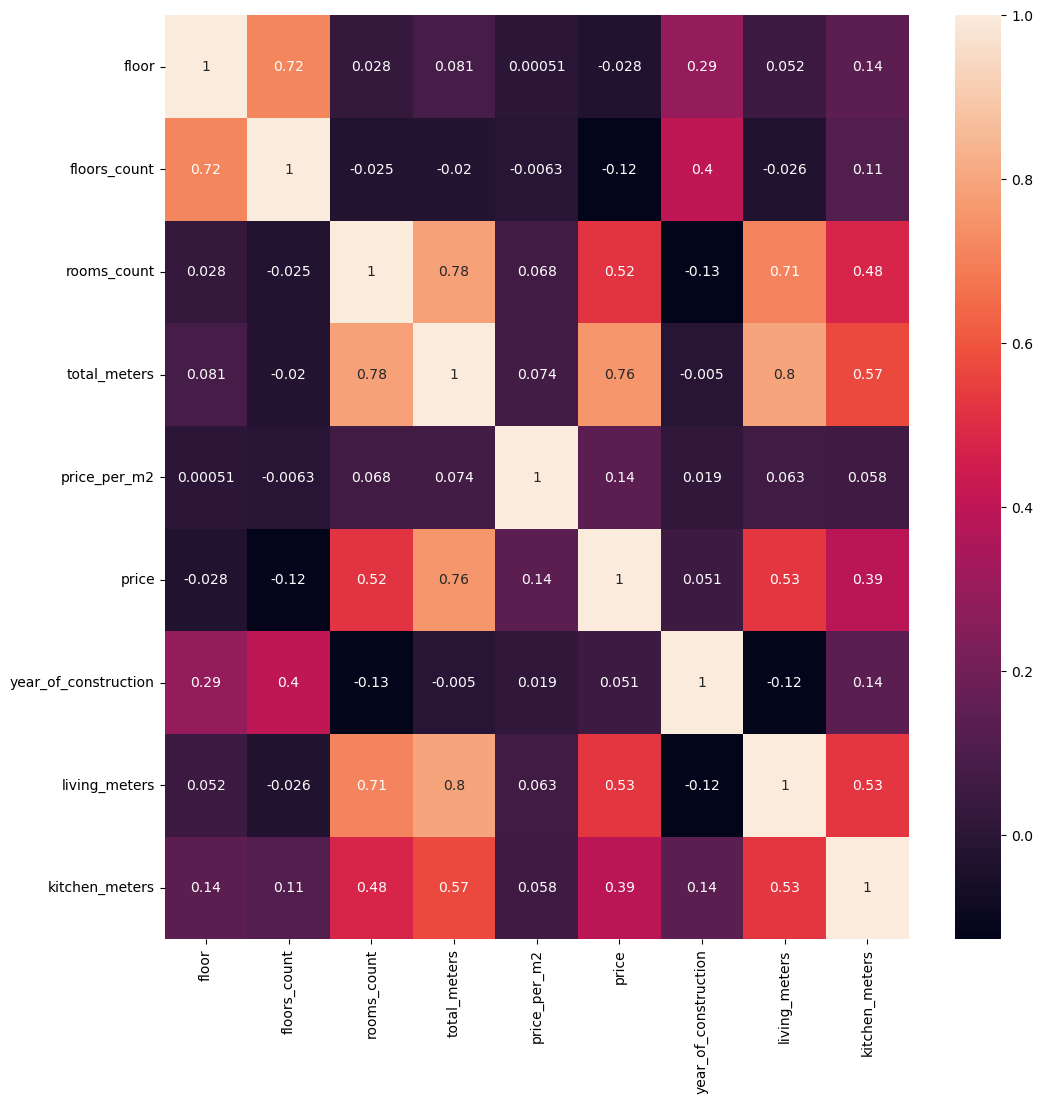

In [46]:
plt.figure(figsize = (12,12))
sns.heatmap(df_cop.drop(columns = 'address').corr(),annot = True)

In [47]:
df_cop.shape

(6235, 10)

In [48]:
for col in df_cop.drop(columns = 'address').columns:
    print(col)
    print(df_cop[df_cop[col]<0][col].unique())

floor
[]
floors_count
[]
rooms_count
[]
total_meters
[]
price_per_m2
[]
price
[]
year_of_construction
[]
living_meters
[]
kitchen_meters
[]


In [49]:
df_cop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6235 entries, 0 to 6234
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   floor                 6235 non-null   float64
 1   floors_count          6235 non-null   float64
 2   rooms_count           6234 non-null   float64
 3   total_meters          6235 non-null   float64
 4   price_per_m2          6235 non-null   int64  
 5   price                 6235 non-null   int64  
 6   year_of_construction  6235 non-null   int64  
 7   living_meters         6235 non-null   float64
 8   kitchen_meters        6235 non-null   float64
 9   address               6235 non-null   object 
dtypes: float64(6), int64(3), object(1)
memory usage: 487.2+ KB


In [50]:
df_cop.dropna(inplace = True)
df_cop.reset_index(drop = True,inplace = True)
df_cop.head(100)

floor  floors_count  rooms_count  total_meters  price_per_m2     price  \
0    17.0          41.0          1.0         40.40        618811  25000000   
1     5.0          14.0          1.0         61.97        919799  57000000   
2     9.0          41.0          1.0         40.50        617283  25000000   
3    12.0          17.0          1.0         47.60        324579  15450000   
4     6.0          13.0          1.0         71.10        983122  69900000   
5    33.0          36.0          1.0         75.00        626666  47000000   
6     9.0          17.0          1.0         37.20        147072   5471080   
7     6.0          41.0          1.0         41.00        724390  29700000   
8    16.0          21.0          1.0         48.00        602708  28930000   
9     5.0           9.0          1.0         32.00        404687  12950000   
10   12.0          26.0          1.0         42.00        402380  16900000   
11   18.0          18.0          1.0         34.00        300000  10200000   
12   24.0          24.0          1.0         32.00        650000  20800000   
13    9.0           9.0          1.0         31.20        365384  11400000   
14    2.0           9.0          1.0         33.00        275757   9100000   
15   15.0          15.0          1.0         38.30        275456  10550000   
16    8.0          16.0          1.0         37.90        285224  10810000   
17    2.0          25.0          1.0         38.00        175000   6650000   
18   34.0          52.0          1.0         42.20        425355  17950000   
19   18.0          22.0          1.0         46.00        652173  30000000   
20    6.0          16.0          1.0         36.20        215359   7796000   
21   21.0          26.0          1.0         36.90        207317   7650000   
22    9.0          12.0          1.0         36.00        238888   8600000   
23   14.0          26.0          1.0         32.50        267692   8700000   
24   14.0          17.0          1.0         33.50        191044   6400000   
25    4.0          27.0          1.0         47.40        411392  19500000   
26    4.0          29.0          1.0         45.00        511111  23000000   
27   17.0          17.0          1.0         38.00        297368  11300000   
28   13.0          25.0          1.0         41.50        224002   9296100   
29   53.0          58.0          1.0         38.50        415584  16000000   
30   20.0          58.0          1.0         37.50        554666  20800000   
31   27.0          48.0          1.0         29.00        565517  16400000   
32    2.0           6.0          1.0         52.20        295019  15400000   
33   22.0          30.0          1.0         37.00        500000  18500000   
34   25.0          58.0          1.0         31.10        549839  17100000   
35   17.0          21.0          1.0         32.80        442073  14500000   
36   22.0          58.0          1.0         40.00        495000  19800000   
37    3.0           5.0          1.0         19.70        375634   7400000   
38    6.0          16.0          1.0         29.20        527397  15400000   
39   13.0          19.0          1.0         43.00        208139   8950000   
40    5.0          25.0          1.0         40.00        237500   9500000   
41   12.0          17.0          1.0         38.00        214473   8150000   
42   12.0          12.0          1.0         32.90        243161   8000000   
43   14.0          15.0          1.0         36.60        259562   9500000   
44   14.0          17.0          1.0         34.90        147564   5150000   
45    3.0           9.0          1.0         29.50        386440  11400000   
46    3.0          29.0          1.0         37.00        459459  17000000   
47   41.0          53.0          1.0         33.90        427728  14500000   
48    4.0           9.0          1.0         30.00        408333  12250000   
49   20.0          25.0          1.0         41.30        145036   5990000   
50    1.0           5.0   

In [51]:
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    #if len(tokens) > 2:
    return tokens
    #return None
    
df_cop['address'] = df_cop['address'].apply(lemmatize)

In [52]:
def concat(text):
    text= ' '.join(text)
    return text

df_cop['address'] = df_cop['address'].apply(concat)

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df_cop['address'])
X_counts.shape

import joblib
joblib.dump(count_vect, 'count_vect.joblib')

['count_vect.joblib']

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer().fit(X_counts)
X_tfidf = tf_transformer.transform(X_counts)
X_tfidf.shape

import joblib
joblib.dump(count_vect, 'tf-idf.joblib')

['tf-idf.joblib']

In [55]:
from sklearn.decomposition import TruncatedSVD
clf = TruncatedSVD(5)
Xpca = clf.fit_transform(X_tfidf)
Xpca

array([[ 4.61576258e-01,  4.03355161e-02,  7.25211920e-01,
         3.25132115e-02, -1.04527168e-02],
       [ 2.25057775e-01,  8.45438181e-01, -2.78968430e-01,
        -2.43464731e-02,  5.47063405e-03],
       [ 4.61576258e-01,  4.03355161e-02,  7.25211920e-01,
         3.25132115e-02, -1.04527168e-02],
       [ 7.86751650e-03,  1.11855028e-02,  1.17314755e-02,
        -9.83965740e-04,  1.62634868e-03],
       [ 2.25057775e-01,  8.45438181e-01, -2.78968430e-01,
        -2.43464731e-02,  5.47063405e-03],
       [ 2.83968494e-02,  3.89455469e-02,  9.20477753e-02,
        -7.64710882e-03,  1.05138791e-02],
       [-2.69455447e-05, -1.77562846e-04,  2.70874365e-04,
         2.33510329e-04, -1.15231624e-04],
       [ 4.61576258e-01,  4.03355161e-02,  7.25211920e-01,
         3.25132115e-02, -1.04527168e-02],
       [ 5.44541799e-01, -2.50782565e-01, -3.81705162e-01,
        -2.12331196e-02,  6.59765055e-03],
       [ 4.37212997e-03,  8.04996352e-03,  9.87129096e-04,
        -7.92442680e-05

In [56]:
df_cop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   floor                 6234 non-null   float64
 1   floors_count          6234 non-null   float64
 2   rooms_count           6234 non-null   float64
 3   total_meters          6234 non-null   float64
 4   price_per_m2          6234 non-null   int64  
 5   price                 6234 non-null   int64  
 6   year_of_construction  6234 non-null   int64  
 7   living_meters         6234 non-null   float64
 8   kitchen_meters        6234 non-null   float64
 9   address               6234 non-null   object 
dtypes: float64(6), int64(3), object(1)
memory usage: 487.2+ KB


# Модели!!!!!!!!!!!!!!!!!!!!!!!!!

<Axes: >

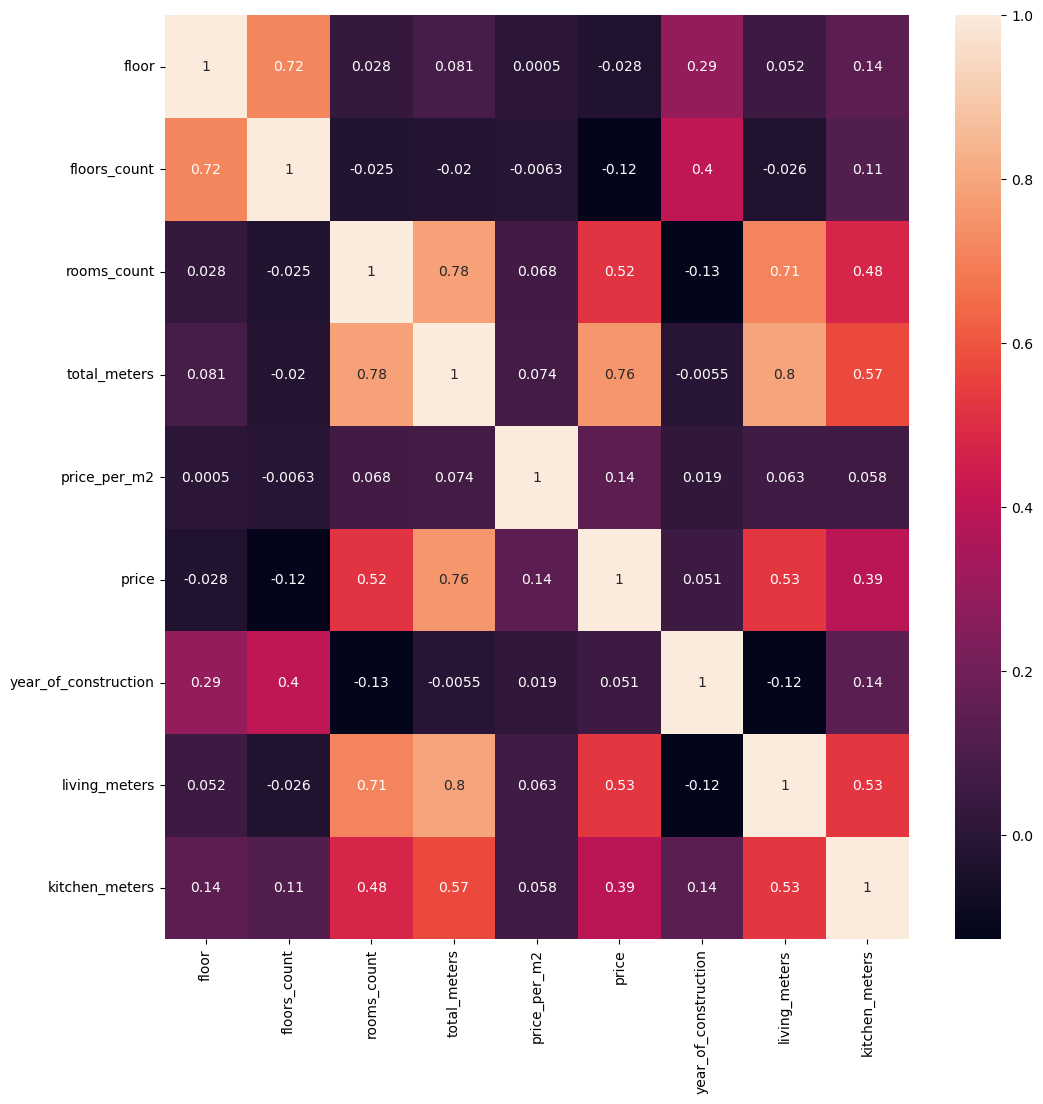

In [57]:
plt.figure(figsize = (12,12))
sns.heatmap(df_cop.drop(columns = 'address').corr(),annot = True)

In [58]:
df_cop.columns

Index(['floor', 'floors_count', 'rooms_count', 'total_meters', 'price_per_m2',
       'price', 'year_of_construction', 'living_meters', 'kitchen_meters',
       'address'],
      dtype='object')

In [59]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2','year_of_construction','living_meters','kitchen_meters'])
y = df_cop['year_of_construction']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [3])
gs.best_params_, gs.best_score_

In [ ]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=7,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [3])

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

import joblib 
joblib.dump(fit_model_price_m2, "years(str3).joblib")

In [ ]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2','living_meters','kitchen_meters'])
y = df_cop['living_meters']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [4])
gs.best_params_, gs.best_score_

In [ ]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=5,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [4])

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))


In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

In [ ]:
import joblib 
joblib.dump(fit_model_price_m2, "liv_metr(str4).joblib")

In [ ]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2','kitchen_meters'])
y = df_cop['kitchen_meters']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [5])
gs.best_params_, gs.best_score_

In [155]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=3,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [5])

0:	learn: 5.4605090	total: 14.3ms	remaining: 14.3s
1:	learn: 5.2352612	total: 29.9ms	remaining: 14.9s
2:	learn: 5.0414441	total: 39.7ms	remaining: 13.2s
3:	learn: 4.9096732	total: 49.3ms	remaining: 12.3s
4:	learn: 4.7606268	total: 61.1ms	remaining: 12.2s
5:	learn: 4.6575756	total: 71.3ms	remaining: 11.8s
6:	learn: 4.5506463	total: 82.4ms	remaining: 11.7s
7:	learn: 4.4798543	total: 89.9ms	remaining: 11.2s
8:	learn: 4.3936216	total: 99.8ms	remaining: 11s
9:	learn: 4.3403029	total: 110ms	remaining: 10.8s
10:	learn: 4.2887567	total: 119ms	remaining: 10.7s
11:	learn: 4.2412157	total: 129ms	remaining: 10.6s
12:	learn: 4.2002583	total: 139ms	remaining: 10.6s
13:	learn: 4.1647813	total: 152ms	remaining: 10.7s
14:	learn: 4.1268933	total: 162ms	remaining: 10.6s
15:	learn: 4.0930295	total: 172ms	remaining: 10.6s
16:	learn: 4.0561264	total: 181ms	remaining: 10.5s
17:	learn: 4.0293234	total: 193ms	remaining: 10.5s
18:	learn: 3.9988905	total: 203ms	remaining: 10.5s
19:	learn: 3.9814106	total: 213ms	

162:	learn: 3.6127908	total: 1.69s	remaining: 8.7s
163:	learn: 3.6119679	total: 1.7s	remaining: 8.69s
164:	learn: 3.6115570	total: 1.72s	remaining: 8.68s
165:	learn: 3.6105954	total: 1.73s	remaining: 8.68s
166:	learn: 3.6103569	total: 1.74s	remaining: 8.67s
167:	learn: 3.6099877	total: 1.75s	remaining: 8.66s
168:	learn: 3.6095324	total: 1.76s	remaining: 8.66s
169:	learn: 3.6082088	total: 1.77s	remaining: 8.66s
170:	learn: 3.6077463	total: 1.78s	remaining: 8.65s
171:	learn: 3.6061425	total: 1.79s	remaining: 8.64s
172:	learn: 3.6041053	total: 1.81s	remaining: 8.64s
173:	learn: 3.6036186	total: 1.82s	remaining: 8.65s
174:	learn: 3.6028628	total: 1.83s	remaining: 8.65s
175:	learn: 3.6016946	total: 1.85s	remaining: 8.64s
176:	learn: 3.6007529	total: 1.86s	remaining: 8.64s
177:	learn: 3.6006694	total: 1.87s	remaining: 8.63s
178:	learn: 3.5991785	total: 1.88s	remaining: 8.62s
179:	learn: 3.5981035	total: 1.89s	remaining: 8.62s
180:	learn: 3.5977148	total: 1.9s	remaining: 8.61s
181:	learn: 3.5

324:	learn: 3.5184199	total: 3.38s	remaining: 7.02s
325:	learn: 3.5179395	total: 3.39s	remaining: 7.01s
326:	learn: 3.5177535	total: 3.4s	remaining: 7s
327:	learn: 3.5173700	total: 3.41s	remaining: 6.99s
328:	learn: 3.5169546	total: 3.42s	remaining: 6.97s
329:	learn: 3.5165830	total: 3.43s	remaining: 6.96s
330:	learn: 3.5160345	total: 3.44s	remaining: 6.94s
331:	learn: 3.5155477	total: 3.44s	remaining: 6.93s
332:	learn: 3.5151927	total: 3.45s	remaining: 6.92s
333:	learn: 3.5146805	total: 3.46s	remaining: 6.9s
334:	learn: 3.5142536	total: 3.47s	remaining: 6.89s
335:	learn: 3.5141657	total: 3.48s	remaining: 6.87s
336:	learn: 3.5136281	total: 3.48s	remaining: 6.86s
337:	learn: 3.5135826	total: 3.49s	remaining: 6.84s
338:	learn: 3.5130577	total: 3.5s	remaining: 6.83s
339:	learn: 3.5129203	total: 3.51s	remaining: 6.82s
340:	learn: 3.5128379	total: 3.52s	remaining: 6.8s
341:	learn: 3.5123885	total: 3.53s	remaining: 6.79s
342:	learn: 3.5114520	total: 3.54s	remaining: 6.78s
343:	learn: 3.51019

496:	learn: 3.4573215	total: 4.86s	remaining: 4.91s
497:	learn: 3.4566472	total: 4.87s	remaining: 4.91s
498:	learn: 3.4565845	total: 4.87s	remaining: 4.89s
499:	learn: 3.4560808	total: 4.88s	remaining: 4.88s
500:	learn: 3.4559167	total: 4.89s	remaining: 4.87s
501:	learn: 3.4558238	total: 4.9s	remaining: 4.86s
502:	learn: 3.4557383	total: 4.91s	remaining: 4.85s
503:	learn: 3.4555569	total: 4.92s	remaining: 4.84s
504:	learn: 3.4548270	total: 4.92s	remaining: 4.83s
505:	learn: 3.4544469	total: 4.93s	remaining: 4.82s
506:	learn: 3.4540552	total: 4.94s	remaining: 4.81s
507:	learn: 3.4533435	total: 4.95s	remaining: 4.79s
508:	learn: 3.4530980	total: 4.96s	remaining: 4.78s
509:	learn: 3.4529529	total: 4.97s	remaining: 4.77s
510:	learn: 3.4525776	total: 4.98s	remaining: 4.76s
511:	learn: 3.4522777	total: 4.99s	remaining: 4.75s
512:	learn: 3.4519823	total: 4.99s	remaining: 4.74s
513:	learn: 3.4519270	total: 5s	remaining: 4.73s
514:	learn: 3.4518692	total: 5.01s	remaining: 4.72s
515:	learn: 3.45

666:	learn: 3.4089952	total: 6.33s	remaining: 3.16s
667:	learn: 3.4087513	total: 6.35s	remaining: 3.15s
668:	learn: 3.4085013	total: 6.36s	remaining: 3.14s
669:	learn: 3.4078655	total: 6.36s	remaining: 3.13s
670:	learn: 3.4077922	total: 6.37s	remaining: 3.12s
671:	learn: 3.4070198	total: 6.38s	remaining: 3.11s
672:	learn: 3.4070142	total: 6.39s	remaining: 3.1s
673:	learn: 3.4063881	total: 6.4s	remaining: 3.09s
674:	learn: 3.4057621	total: 6.41s	remaining: 3.08s
675:	learn: 3.4051821	total: 6.42s	remaining: 3.08s
676:	learn: 3.4050624	total: 6.42s	remaining: 3.06s
677:	learn: 3.4050218	total: 6.43s	remaining: 3.06s
678:	learn: 3.4043659	total: 6.44s	remaining: 3.04s
679:	learn: 3.4039587	total: 6.45s	remaining: 3.04s
680:	learn: 3.4035894	total: 6.46s	remaining: 3.02s
681:	learn: 3.4034494	total: 6.47s	remaining: 3.02s
682:	learn: 3.4031107	total: 6.47s	remaining: 3s
683:	learn: 3.4029582	total: 6.48s	remaining: 3s
684:	learn: 3.4029090	total: 6.49s	remaining: 2.98s
685:	learn: 3.402802

836:	learn: 3.3698282	total: 7.79s	remaining: 1.52s
837:	learn: 3.3695518	total: 7.8s	remaining: 1.51s
838:	learn: 3.3694966	total: 7.81s	remaining: 1.5s
839:	learn: 3.3693934	total: 7.82s	remaining: 1.49s
840:	learn: 3.3690721	total: 7.83s	remaining: 1.48s
841:	learn: 3.3688139	total: 7.83s	remaining: 1.47s
842:	learn: 3.3684120	total: 7.84s	remaining: 1.46s
843:	learn: 3.3682853	total: 7.85s	remaining: 1.45s
844:	learn: 3.3681417	total: 7.86s	remaining: 1.44s
845:	learn: 3.3680448	total: 7.87s	remaining: 1.43s
846:	learn: 3.3678355	total: 7.88s	remaining: 1.42s
847:	learn: 3.3678236	total: 7.88s	remaining: 1.41s
848:	learn: 3.3677937	total: 7.89s	remaining: 1.4s
849:	learn: 3.3675390	total: 7.9s	remaining: 1.39s
850:	learn: 3.3672955	total: 7.91s	remaining: 1.38s
851:	learn: 3.3672852	total: 7.92s	remaining: 1.38s
852:	learn: 3.3672609	total: 7.92s	remaining: 1.36s
853:	learn: 3.3671683	total: 7.93s	remaining: 1.36s
854:	learn: 3.3670227	total: 7.94s	remaining: 1.35s
855:	learn: 3.36

In [156]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

3.531205849792863

In [157]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.3498853460056346

In [158]:
import joblib 
joblib.dump(fit_model_price_m2, "kitch_metr(str5).joblib")

['kitch_metr(str5).joblib']

## Берём модель т.к. резы с просто среднего по кол-во комнат удручают

In [169]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_cop['kitchen_meters'], kit_met)

4.7079146615335254

In [170]:
from sklearn.metrics import r2_score
r2_score(df_cop['kitchen_meters'], kit_met)

0.2457376921964448

In [120]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2'])
y = df_cop['total_meters']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [110]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X.drop(columns = 'address'))

In [115]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [6])
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 25 candidates, totalling 50 fits



KeyboardInterrupt



In [117]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=7,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [6])


0:	learn: 55.6399693	total: 30.6ms	remaining: 30.6s
1:	learn: 51.0412095	total: 51.4ms	remaining: 25.6s
2:	learn: 47.0809749	total: 71.2ms	remaining: 23.7s
3:	learn: 43.5956473	total: 89.2ms	remaining: 22.2s
4:	learn: 40.6764682	total: 109ms	remaining: 21.7s
5:	learn: 38.0704531	total: 129ms	remaining: 21.4s
6:	learn: 35.8554292	total: 149ms	remaining: 21.1s
7:	learn: 33.8105256	total: 168ms	remaining: 20.9s
8:	learn: 32.0853762	total: 188ms	remaining: 20.7s
9:	learn: 30.5242531	total: 208ms	remaining: 20.5s
10:	learn: 29.2878946	total: 227ms	remaining: 20.4s
11:	learn: 28.1836762	total: 249ms	remaining: 20.5s
12:	learn: 27.1726966	total: 273ms	remaining: 20.7s
13:	learn: 26.2275822	total: 293ms	remaining: 20.6s
14:	learn: 25.3283480	total: 313ms	remaining: 20.5s
15:	learn: 24.5438212	total: 332ms	remaining: 20.4s
16:	learn: 23.8148850	total: 352ms	remaining: 20.4s
17:	learn: 23.2329858	total: 373ms	remaining: 20.4s
18:	learn: 22.7691460	total: 393ms	remaining: 20.3s
19:	learn: 22.3966

165:	learn: 14.6437914	total: 3.35s	remaining: 16.8s
166:	learn: 14.6394851	total: 3.37s	remaining: 16.8s
167:	learn: 14.6015863	total: 3.39s	remaining: 16.8s
168:	learn: 14.5951670	total: 3.41s	remaining: 16.8s
169:	learn: 14.5924850	total: 3.43s	remaining: 16.7s
170:	learn: 14.5831957	total: 3.45s	remaining: 16.7s
171:	learn: 14.5419118	total: 3.47s	remaining: 16.7s
172:	learn: 14.5316790	total: 3.49s	remaining: 16.7s
173:	learn: 14.5201789	total: 3.51s	remaining: 16.7s
174:	learn: 14.4815346	total: 3.53s	remaining: 16.6s
175:	learn: 14.4750052	total: 3.55s	remaining: 16.6s
176:	learn: 14.4421160	total: 3.57s	remaining: 16.6s
177:	learn: 14.4361601	total: 3.59s	remaining: 16.6s
178:	learn: 14.4161282	total: 3.61s	remaining: 16.6s
179:	learn: 14.4013008	total: 3.63s	remaining: 16.5s
180:	learn: 14.3805521	total: 3.65s	remaining: 16.5s
181:	learn: 14.3541164	total: 3.67s	remaining: 16.5s
182:	learn: 14.3086344	total: 3.69s	remaining: 16.5s
183:	learn: 14.2982591	total: 3.71s	remaining:

326:	learn: 12.5591579	total: 6.65s	remaining: 13.7s
327:	learn: 12.5512260	total: 6.67s	remaining: 13.7s
328:	learn: 12.5417005	total: 6.69s	remaining: 13.7s
329:	learn: 12.5399748	total: 6.72s	remaining: 13.6s
330:	learn: 12.5278510	total: 6.74s	remaining: 13.6s
331:	learn: 12.5210850	total: 6.76s	remaining: 13.6s
332:	learn: 12.5177455	total: 6.79s	remaining: 13.6s
333:	learn: 12.5126957	total: 6.81s	remaining: 13.6s
334:	learn: 12.5097236	total: 6.83s	remaining: 13.6s
335:	learn: 12.4881708	total: 6.86s	remaining: 13.6s
336:	learn: 12.4782884	total: 6.88s	remaining: 13.5s
337:	learn: 12.4739538	total: 6.9s	remaining: 13.5s
338:	learn: 12.4596447	total: 6.92s	remaining: 13.5s
339:	learn: 12.4534993	total: 6.95s	remaining: 13.5s
340:	learn: 12.4417060	total: 6.97s	remaining: 13.5s
341:	learn: 12.4407736	total: 6.99s	remaining: 13.5s
342:	learn: 12.4344100	total: 7.01s	remaining: 13.4s
343:	learn: 12.4313397	total: 7.04s	remaining: 13.4s
344:	learn: 12.4189964	total: 7.06s	remaining: 

488:	learn: 11.5517012	total: 10.2s	remaining: 10.6s
489:	learn: 11.5509599	total: 10.2s	remaining: 10.6s
490:	learn: 11.5501181	total: 10.2s	remaining: 10.6s
491:	learn: 11.5479070	total: 10.2s	remaining: 10.6s
492:	learn: 11.5460677	total: 10.3s	remaining: 10.6s
493:	learn: 11.5406115	total: 10.3s	remaining: 10.5s
494:	learn: 11.5395016	total: 10.3s	remaining: 10.5s
495:	learn: 11.5365030	total: 10.3s	remaining: 10.5s
496:	learn: 11.5352378	total: 10.3s	remaining: 10.5s
497:	learn: 11.5321978	total: 10.4s	remaining: 10.4s
498:	learn: 11.5256682	total: 10.4s	remaining: 10.4s
499:	learn: 11.5243211	total: 10.4s	remaining: 10.4s
500:	learn: 11.5190915	total: 10.4s	remaining: 10.4s
501:	learn: 11.5100324	total: 10.4s	remaining: 10.4s
502:	learn: 11.4988642	total: 10.5s	remaining: 10.3s
503:	learn: 11.4876525	total: 10.5s	remaining: 10.3s
504:	learn: 11.4861769	total: 10.5s	remaining: 10.3s
505:	learn: 11.4833792	total: 10.5s	remaining: 10.3s
506:	learn: 11.4809743	total: 10.5s	remaining:

653:	learn: 10.8212462	total: 13.4s	remaining: 7.1s
654:	learn: 10.8209434	total: 13.5s	remaining: 7.08s
655:	learn: 10.8150524	total: 13.5s	remaining: 7.06s
656:	learn: 10.8136507	total: 13.5s	remaining: 7.04s
657:	learn: 10.8085143	total: 13.5s	remaining: 7.02s
658:	learn: 10.8021246	total: 13.5s	remaining: 7s
659:	learn: 10.8004407	total: 13.5s	remaining: 6.98s
660:	learn: 10.7989980	total: 13.6s	remaining: 6.96s
661:	learn: 10.7979206	total: 13.6s	remaining: 6.94s
662:	learn: 10.7978228	total: 13.6s	remaining: 6.92s
663:	learn: 10.7964283	total: 13.6s	remaining: 6.89s
664:	learn: 10.7953850	total: 13.6s	remaining: 6.87s
665:	learn: 10.7889959	total: 13.7s	remaining: 6.85s
666:	learn: 10.7873298	total: 13.7s	remaining: 6.83s
667:	learn: 10.7861742	total: 13.7s	remaining: 6.81s
668:	learn: 10.7840694	total: 13.7s	remaining: 6.79s
669:	learn: 10.7801987	total: 13.7s	remaining: 6.77s
670:	learn: 10.7784158	total: 13.8s	remaining: 6.75s
671:	learn: 10.7724443	total: 13.8s	remaining: 6.7

817:	learn: 10.3012919	total: 16.7s	remaining: 3.71s
818:	learn: 10.2960437	total: 16.7s	remaining: 3.69s
819:	learn: 10.2911214	total: 16.7s	remaining: 3.67s
820:	learn: 10.2889655	total: 16.7s	remaining: 3.65s
821:	learn: 10.2857229	total: 16.7s	remaining: 3.62s
822:	learn: 10.2850993	total: 16.8s	remaining: 3.6s
823:	learn: 10.2753423	total: 16.8s	remaining: 3.58s
824:	learn: 10.2749632	total: 16.8s	remaining: 3.56s
825:	learn: 10.2741733	total: 16.8s	remaining: 3.54s
826:	learn: 10.2698096	total: 16.8s	remaining: 3.52s
827:	learn: 10.2638522	total: 16.9s	remaining: 3.5s
828:	learn: 10.2610913	total: 16.9s	remaining: 3.48s
829:	learn: 10.2596045	total: 16.9s	remaining: 3.46s
830:	learn: 10.2584971	total: 16.9s	remaining: 3.44s
831:	learn: 10.2569529	total: 16.9s	remaining: 3.42s
832:	learn: 10.2553056	total: 17s	remaining: 3.4s
833:	learn: 10.2536644	total: 17s	remaining: 3.38s
834:	learn: 10.2528223	total: 17s	remaining: 3.36s
835:	learn: 10.2526148	total: 17s	remaining: 3.34s
836:

980:	learn: 9.8720841	total: 19.9s	remaining: 386ms
981:	learn: 9.8659380	total: 19.9s	remaining: 366ms
982:	learn: 9.8605594	total: 20s	remaining: 345ms
983:	learn: 9.8563482	total: 20s	remaining: 325ms
984:	learn: 9.8557312	total: 20s	remaining: 305ms
985:	learn: 9.8510600	total: 20s	remaining: 284ms
986:	learn: 9.8500866	total: 20s	remaining: 264ms
987:	learn: 9.8498621	total: 20.1s	remaining: 244ms
988:	learn: 9.8497244	total: 20.1s	remaining: 223ms
989:	learn: 9.8495416	total: 20.1s	remaining: 203ms
990:	learn: 9.8488268	total: 20.1s	remaining: 183ms
991:	learn: 9.8452483	total: 20.1s	remaining: 162ms
992:	learn: 9.8418839	total: 20.2s	remaining: 142ms
993:	learn: 9.8412503	total: 20.2s	remaining: 122ms
994:	learn: 9.8405130	total: 20.2s	remaining: 102ms
995:	learn: 9.8385744	total: 20.2s	remaining: 81.2ms
996:	learn: 9.8377696	total: 20.2s	remaining: 60.9ms
997:	learn: 9.8372234	total: 20.3s	remaining: 40.6ms
998:	learn: 9.8338689	total: 20.3s	remaining: 20.3ms
999:	learn: 9.8324

import joblib
joblib.dump(fit_model_price_m2, "tot_metr.joblib")

In [118]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

15.980408559583458

In [119]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.8512455082669705

In [187]:
metr = fit_model_price_m2.predict(X)

In [84]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2'])
X['total_meters'] = metr
y = df_cop['price']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [85]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [6])
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 25 candidates, totalling 50 fits
0:	learn: 53806882.4332842	total: 29.4ms	remaining: 29.3s
1:	learn: 50323379.9735225	total: 59.5ms	remaining: 29.7s
2:	learn: 47351683.8771881	total: 88.5ms	remaining: 29.4s
3:	learn: 45197295.7485470	total: 120ms	remaining: 29.8s
4:	learn: 43107454.4260624	total: 151ms	remaining: 30.1s
5:	learn: 41602294.9489257	total: 182ms	remaining: 30.1s
6:	learn: 39848802.5063096	total: 213ms	remaining: 30.2s
7:	learn: 38507850.6048403	total: 246ms	remaining: 30.4s
8:	learn: 37224875.1522664	total: 295ms	remaining: 32.4s
9:	learn: 36087134.6571094	total: 326ms	remaining: 32.3s
10:	learn: 35040887.7776681	total: 358ms	remaining: 32.2s
11:	learn: 34198434.0992919	total: 406ms	remaining: 33.4s
12:	learn: 33423283.1098887	total: 459ms	remaining: 34.8s
13:	learn: 32672839.0658659	total: 511ms	remaining: 36s
14:	learn: 32161492.8688039	total: 551ms	remaining: 36.2s
15:	learn: 31674404.6175649	total: 587ms	remaining: 36.1s
16:	learn: 31004101.

141:	learn: 19151102.2967584	total: 4.97s	remaining: 30s
142:	learn: 19131490.1010377	total: 5s	remaining: 30s
143:	learn: 19124569.9406547	total: 5.04s	remaining: 29.9s
144:	learn: 19110129.3459552	total: 5.07s	remaining: 29.9s
145:	learn: 19021473.2716993	total: 5.1s	remaining: 29.8s
146:	learn: 18976421.4400817	total: 5.13s	remaining: 29.8s
147:	learn: 18961430.1741778	total: 5.16s	remaining: 29.7s
148:	learn: 18947526.0363215	total: 5.19s	remaining: 29.7s
149:	learn: 18942891.8744049	total: 5.22s	remaining: 29.6s
150:	learn: 18936231.5454915	total: 5.26s	remaining: 29.6s
151:	learn: 18908983.6869329	total: 5.29s	remaining: 29.5s
152:	learn: 18815752.1318084	total: 5.32s	remaining: 29.4s
153:	learn: 18788815.8077311	total: 5.35s	remaining: 29.4s
154:	learn: 18758217.7127010	total: 5.38s	remaining: 29.3s
155:	learn: 18746912.1168737	total: 5.42s	remaining: 29.3s
156:	learn: 18726376.4111233	total: 5.46s	remaining: 29.3s
157:	learn: 18612833.5433609	total: 5.49s	remaining: 29.3s
158:	

287:	learn: 14562836.2293495	total: 9.61s	remaining: 23.8s
288:	learn: 14557151.6310769	total: 9.64s	remaining: 23.7s
289:	learn: 14532033.5653620	total: 9.67s	remaining: 23.7s
290:	learn: 14480192.5168903	total: 9.71s	remaining: 23.6s
291:	learn: 14469356.7162194	total: 9.74s	remaining: 23.6s
292:	learn: 14452005.9909357	total: 9.77s	remaining: 23.6s
293:	learn: 14434896.7559325	total: 9.8s	remaining: 23.5s
294:	learn: 14430087.7177498	total: 9.83s	remaining: 23.5s
295:	learn: 14425704.3936318	total: 9.86s	remaining: 23.5s
296:	learn: 14391828.8675870	total: 9.9s	remaining: 23.4s
297:	learn: 14380745.3164151	total: 9.93s	remaining: 23.4s
298:	learn: 14373692.2819786	total: 9.96s	remaining: 23.4s
299:	learn: 14362357.2503242	total: 9.99s	remaining: 23.3s
300:	learn: 14337761.6225268	total: 10s	remaining: 23.3s
301:	learn: 14335193.6946589	total: 10.1s	remaining: 23.2s
302:	learn: 14332535.0890400	total: 10.1s	remaining: 23.2s
303:	learn: 14326412.7730522	total: 10.1s	remaining: 23.2s
3

431:	learn: 12243930.5324103	total: 14.1s	remaining: 18.5s
432:	learn: 12230231.2249520	total: 14.1s	remaining: 18.5s
433:	learn: 12206130.6395059	total: 14.2s	remaining: 18.5s
434:	learn: 12205206.6503029	total: 14.2s	remaining: 18.4s
435:	learn: 12200977.6847817	total: 14.2s	remaining: 18.4s
436:	learn: 12192490.5377974	total: 14.2s	remaining: 18.3s
437:	learn: 12188686.4839695	total: 14.3s	remaining: 18.3s
438:	learn: 12183262.9780664	total: 14.3s	remaining: 18.3s
439:	learn: 12174486.4001629	total: 14.3s	remaining: 18.2s
440:	learn: 12163535.6087900	total: 14.4s	remaining: 18.2s
441:	learn: 12138525.4436231	total: 14.4s	remaining: 18.2s
442:	learn: 12136427.0125589	total: 14.4s	remaining: 18.2s
443:	learn: 12131411.6198049	total: 14.5s	remaining: 18.1s
444:	learn: 12115358.8185129	total: 14.5s	remaining: 18.1s
445:	learn: 12112849.3607078	total: 14.5s	remaining: 18.1s
446:	learn: 12101986.0526336	total: 14.6s	remaining: 18s
447:	learn: 12094026.7971551	total: 14.6s	remaining: 18s
4

573:	learn: 10930148.7195707	total: 18.8s	remaining: 14s
574:	learn: 10928540.5312507	total: 18.8s	remaining: 13.9s
575:	learn: 10923806.7833914	total: 18.9s	remaining: 13.9s
576:	learn: 10920276.6953840	total: 18.9s	remaining: 13.8s
577:	learn: 10917773.1129948	total: 18.9s	remaining: 13.8s
578:	learn: 10914666.6623186	total: 19s	remaining: 13.8s
579:	learn: 10907694.2801479	total: 19s	remaining: 13.7s
580:	learn: 10905482.1328454	total: 19s	remaining: 13.7s
581:	learn: 10902351.5981521	total: 19s	remaining: 13.7s
582:	learn: 10893812.2467450	total: 19.1s	remaining: 13.6s
583:	learn: 10892591.6453647	total: 19.1s	remaining: 13.6s
584:	learn: 10887201.1512012	total: 19.1s	remaining: 13.6s
585:	learn: 10880129.4330595	total: 19.2s	remaining: 13.5s
586:	learn: 10876371.2767423	total: 19.2s	remaining: 13.5s
587:	learn: 10875239.8731451	total: 19.2s	remaining: 13.5s
588:	learn: 10873512.5199141	total: 19.3s	remaining: 13.4s
589:	learn: 10868429.8949772	total: 19.3s	remaining: 13.4s
590:	le

713:	learn: 10043580.2540914	total: 23.9s	remaining: 9.56s
714:	learn: 10038098.6055347	total: 23.9s	remaining: 9.53s
715:	learn: 10035472.4366409	total: 24s	remaining: 9.5s
716:	learn: 10033671.9020075	total: 24s	remaining: 9.47s
717:	learn: 10026917.8327610	total: 24s	remaining: 9.44s
718:	learn: 10024771.6108721	total: 24.1s	remaining: 9.4s
719:	learn: 10006273.1244077	total: 24.1s	remaining: 9.38s
720:	learn: 9998954.5862130	total: 24.1s	remaining: 9.35s
721:	learn: 9997808.1638039	total: 24.2s	remaining: 9.31s
722:	learn: 9993462.3534658	total: 24.2s	remaining: 9.28s
723:	learn: 9992316.9604060	total: 24.3s	remaining: 9.25s
724:	learn: 9984072.6031474	total: 24.3s	remaining: 9.21s
725:	learn: 9980918.4977052	total: 24.3s	remaining: 9.18s
726:	learn: 9980776.4019196	total: 24.4s	remaining: 9.15s
727:	learn: 9974935.7804306	total: 24.4s	remaining: 9.12s
728:	learn: 9972146.3758821	total: 24.5s	remaining: 9.09s
729:	learn: 9971306.2809658	total: 24.5s	remaining: 9.06s
730:	learn: 996

860:	learn: 9503954.3854692	total: 29.2s	remaining: 4.71s
861:	learn: 9502407.1370948	total: 29.2s	remaining: 4.68s
862:	learn: 9501366.7091263	total: 29.2s	remaining: 4.64s
863:	learn: 9499337.3208698	total: 29.3s	remaining: 4.61s
864:	learn: 9494464.3661982	total: 29.3s	remaining: 4.57s
865:	learn: 9493937.1642586	total: 29.3s	remaining: 4.54s
866:	learn: 9488487.6923861	total: 29.4s	remaining: 4.51s
867:	learn: 9480011.0107319	total: 29.4s	remaining: 4.47s
868:	learn: 9479096.2017814	total: 29.4s	remaining: 4.44s
869:	learn: 9459890.0739911	total: 29.5s	remaining: 4.4s
870:	learn: 9448253.0206476	total: 29.5s	remaining: 4.37s
871:	learn: 9443814.1783544	total: 29.5s	remaining: 4.33s
872:	learn: 9442689.6848725	total: 29.6s	remaining: 4.3s
873:	learn: 9442192.6617142	total: 29.6s	remaining: 4.27s
874:	learn: 9436931.7682249	total: 29.6s	remaining: 4.23s
875:	learn: 9430892.6781320	total: 29.7s	remaining: 4.2s
876:	learn: 9427681.9503108	total: 29.7s	remaining: 4.16s
877:	learn: 94037

({'depth': 9, 'learning_rate': 0.1}, 0.6151032842536429)

In [86]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=9,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [6])

0:	learn: 53806882.4332842	total: 46ms	remaining: 45.9s
1:	learn: 50323379.9735225	total: 84.7ms	remaining: 42.3s
2:	learn: 47351683.8771881	total: 123ms	remaining: 41s
3:	learn: 45197295.7485470	total: 164ms	remaining: 40.9s
4:	learn: 43107454.4260624	total: 213ms	remaining: 42.5s
5:	learn: 41602294.9489257	total: 246ms	remaining: 40.7s
6:	learn: 39848802.5063096	total: 281ms	remaining: 39.9s
7:	learn: 38507850.6048403	total: 326ms	remaining: 40.5s
8:	learn: 37224875.1522664	total: 356ms	remaining: 39.2s
9:	learn: 36087134.6571094	total: 390ms	remaining: 38.6s
10:	learn: 35040887.7776681	total: 420ms	remaining: 37.7s
11:	learn: 34198434.0992919	total: 450ms	remaining: 37.1s
12:	learn: 33423283.1098887	total: 483ms	remaining: 36.7s
13:	learn: 32672839.0658659	total: 519ms	remaining: 36.5s
14:	learn: 32161492.8688039	total: 550ms	remaining: 36.1s
15:	learn: 31674404.6175649	total: 580ms	remaining: 35.7s
16:	learn: 31004101.0549417	total: 611ms	remaining: 35.3s
17:	learn: 30491855.877365

146:	learn: 18976421.4400817	total: 5.22s	remaining: 30.3s
147:	learn: 18961430.1741778	total: 5.25s	remaining: 30.2s
148:	learn: 18947526.0363215	total: 5.28s	remaining: 30.2s
149:	learn: 18942891.8744049	total: 5.31s	remaining: 30.1s
150:	learn: 18936231.5454915	total: 5.34s	remaining: 30s
151:	learn: 18908983.6869329	total: 5.37s	remaining: 30s
152:	learn: 18815752.1318084	total: 5.4s	remaining: 29.9s
153:	learn: 18788815.8077311	total: 5.43s	remaining: 29.8s
154:	learn: 18758217.7127010	total: 5.46s	remaining: 29.8s
155:	learn: 18746912.1168737	total: 5.5s	remaining: 29.7s
156:	learn: 18726376.4111233	total: 5.53s	remaining: 29.7s
157:	learn: 18612833.5433609	total: 5.56s	remaining: 29.6s
158:	learn: 18565927.4585346	total: 5.59s	remaining: 29.6s
159:	learn: 18503437.5091932	total: 5.62s	remaining: 29.5s
160:	learn: 18469027.9760036	total: 5.65s	remaining: 29.5s
161:	learn: 18413282.4734303	total: 5.68s	remaining: 29.4s
162:	learn: 18394862.9627444	total: 5.71s	remaining: 29.3s
163

287:	learn: 14562836.2293495	total: 10.1s	remaining: 24.9s
288:	learn: 14557151.6310769	total: 10.1s	remaining: 24.9s
289:	learn: 14532033.5653620	total: 10.1s	remaining: 24.8s
290:	learn: 14480192.5168903	total: 10.2s	remaining: 24.8s
291:	learn: 14469356.7162194	total: 10.2s	remaining: 24.7s
292:	learn: 14452005.9909357	total: 10.2s	remaining: 24.7s
293:	learn: 14434896.7559325	total: 10.3s	remaining: 24.7s
294:	learn: 14430087.7177498	total: 10.3s	remaining: 24.6s
295:	learn: 14425704.3936318	total: 10.3s	remaining: 24.6s
296:	learn: 14391828.8675870	total: 10.4s	remaining: 24.5s
297:	learn: 14380745.3164151	total: 10.4s	remaining: 24.5s
298:	learn: 14373692.2819786	total: 10.4s	remaining: 24.4s
299:	learn: 14362357.2503242	total: 10.4s	remaining: 24.4s
300:	learn: 14337761.6225268	total: 10.5s	remaining: 24.3s
301:	learn: 14335193.6946589	total: 10.5s	remaining: 24.3s
302:	learn: 14332535.0890400	total: 10.5s	remaining: 24.3s
303:	learn: 14326412.7730522	total: 10.6s	remaining: 24.

433:	learn: 12206130.6395059	total: 14.9s	remaining: 19.4s
434:	learn: 12205206.6503029	total: 14.9s	remaining: 19.4s
435:	learn: 12200977.6847817	total: 14.9s	remaining: 19.3s
436:	learn: 12192490.5377974	total: 15s	remaining: 19.3s
437:	learn: 12188686.4839695	total: 15s	remaining: 19.2s
438:	learn: 12183262.9780664	total: 15s	remaining: 19.2s
439:	learn: 12174486.4001629	total: 15.1s	remaining: 19.2s
440:	learn: 12163535.6087900	total: 15.1s	remaining: 19.1s
441:	learn: 12138525.4436231	total: 15.1s	remaining: 19.1s
442:	learn: 12136427.0125589	total: 15.2s	remaining: 19.1s
443:	learn: 12131411.6198049	total: 15.2s	remaining: 19s
444:	learn: 12115358.8185129	total: 15.2s	remaining: 19s
445:	learn: 12112849.3607078	total: 15.3s	remaining: 19s
446:	learn: 12101986.0526336	total: 15.3s	remaining: 18.9s
447:	learn: 12094026.7971551	total: 15.3s	remaining: 18.9s
448:	learn: 12093102.2506770	total: 15.3s	remaining: 18.8s
449:	learn: 12086205.3344514	total: 15.4s	remaining: 18.8s
450:	lear

576:	learn: 10920276.6953840	total: 19.4s	remaining: 14.2s
577:	learn: 10917773.1129948	total: 19.4s	remaining: 14.2s
578:	learn: 10914666.6623186	total: 19.4s	remaining: 14.1s
579:	learn: 10907694.2801479	total: 19.5s	remaining: 14.1s
580:	learn: 10905482.1328454	total: 19.5s	remaining: 14.1s
581:	learn: 10902351.5981521	total: 19.5s	remaining: 14s
582:	learn: 10893812.2467450	total: 19.6s	remaining: 14s
583:	learn: 10892591.6453647	total: 19.6s	remaining: 14s
584:	learn: 10887201.1512012	total: 19.6s	remaining: 13.9s
585:	learn: 10880129.4330595	total: 19.7s	remaining: 13.9s
586:	learn: 10876371.2767423	total: 19.7s	remaining: 13.9s
587:	learn: 10875239.8731451	total: 19.7s	remaining: 13.8s
588:	learn: 10873512.5199141	total: 19.8s	remaining: 13.8s
589:	learn: 10868429.8949772	total: 19.8s	remaining: 13.7s
590:	learn: 10858267.2655355	total: 19.8s	remaining: 13.7s
591:	learn: 10855256.9424486	total: 19.8s	remaining: 13.7s
592:	learn: 10831536.9642326	total: 19.9s	remaining: 13.6s
593

718:	learn: 10024771.6108721	total: 23.7s	remaining: 9.28s
719:	learn: 10006273.1244077	total: 23.8s	remaining: 9.24s
720:	learn: 9998954.5862130	total: 23.8s	remaining: 9.21s
721:	learn: 9997808.1638039	total: 23.8s	remaining: 9.18s
722:	learn: 9993462.3534658	total: 23.9s	remaining: 9.14s
723:	learn: 9992316.9604060	total: 23.9s	remaining: 9.11s
724:	learn: 9984072.6031474	total: 23.9s	remaining: 9.07s
725:	learn: 9980918.4977052	total: 24s	remaining: 9.04s
726:	learn: 9980776.4019196	total: 24s	remaining: 9.01s
727:	learn: 9974935.7804306	total: 24s	remaining: 8.97s
728:	learn: 9972146.3758821	total: 24.1s	remaining: 8.94s
729:	learn: 9971306.2809658	total: 24.1s	remaining: 8.91s
730:	learn: 9967885.7059619	total: 24.1s	remaining: 8.88s
731:	learn: 9966448.7565908	total: 24.2s	remaining: 8.85s
732:	learn: 9964962.8257860	total: 24.2s	remaining: 8.81s
733:	learn: 9962879.5600785	total: 24.2s	remaining: 8.78s
734:	learn: 9961339.9689475	total: 24.3s	remaining: 8.75s
735:	learn: 995226

861:	learn: 9502407.1370948	total: 28.6s	remaining: 4.58s
862:	learn: 9501366.7091263	total: 28.7s	remaining: 4.55s
863:	learn: 9499337.3208698	total: 28.7s	remaining: 4.52s
864:	learn: 9494464.3661982	total: 28.7s	remaining: 4.49s
865:	learn: 9493937.1642586	total: 28.8s	remaining: 4.45s
866:	learn: 9488487.6923861	total: 28.8s	remaining: 4.42s
867:	learn: 9480011.0107319	total: 28.9s	remaining: 4.39s
868:	learn: 9479096.2017814	total: 28.9s	remaining: 4.36s
869:	learn: 9459890.0739911	total: 29s	remaining: 4.33s
870:	learn: 9448253.0206476	total: 29s	remaining: 4.3s
871:	learn: 9443814.1783544	total: 29.1s	remaining: 4.27s
872:	learn: 9442689.6848725	total: 29.1s	remaining: 4.24s
873:	learn: 9442192.6617142	total: 29.2s	remaining: 4.21s
874:	learn: 9436931.7682249	total: 29.2s	remaining: 4.17s
875:	learn: 9430892.6781320	total: 29.3s	remaining: 4.14s
876:	learn: 9427681.9503108	total: 29.3s	remaining: 4.11s
877:	learn: 9403725.3672481	total: 29.3s	remaining: 4.08s
878:	learn: 9400974

import joblib
joblib.dump(fit_model_price_m2, "tot_price.joblib")

In [87]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

24170767.537616163

In [88]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.6700797528420734

In [190]:
price = fit_model_price_m2.predict(X)

In [90]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2'])
X['total_meters'] = metr
X['price'] = price
y = df_cop['price_per_m2']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [92]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [6])
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 25 candidates, totalling 50 fits
0:	learn: 275287.1191845	total: 13.1ms	remaining: 13.1s
1:	learn: 265022.3069991	total: 26.7ms	remaining: 13.3s
2:	learn: 255072.6627354	total: 40.2ms	remaining: 13.4s
3:	learn: 244683.3603736	total: 55.4ms	remaining: 13.8s
4:	learn: 234523.5364157	total: 70.6ms	remaining: 14s
5:	learn: 227282.0537924	total: 85.4ms	remaining: 14.2s
6:	learn: 219256.8143776	total: 101ms	remaining: 14.3s
7:	learn: 213639.7108144	total: 115ms	remaining: 14.3s
8:	learn: 206746.7520846	total: 130ms	remaining: 14.3s
9:	learn: 201958.7895529	total: 144ms	remaining: 14.3s
10:	learn: 196918.4367395	total: 159ms	remaining: 14.3s
11:	learn: 193156.3129199	total: 174ms	remaining: 14.3s
12:	learn: 189910.0379416	total: 188ms	remaining: 14.2s
13:	learn: 186773.8801415	total: 201ms	remaining: 14.2s
14:	learn: 184296.7688134	total: 215ms	remaining: 14.1s
15:	learn: 181103.2893034	total: 234ms	remaining: 14.4s
16:	learn: 179191.1790478	total: 252ms	remaining:

157:	learn: 125268.5130523	total: 2.35s	remaining: 12.5s
158:	learn: 125218.8845735	total: 2.37s	remaining: 12.5s
159:	learn: 125187.0696403	total: 2.38s	remaining: 12.5s
160:	learn: 124992.8954873	total: 2.39s	remaining: 12.5s
161:	learn: 124831.9365332	total: 2.41s	remaining: 12.5s
162:	learn: 124789.4056794	total: 2.42s	remaining: 12.4s
163:	learn: 124759.2488372	total: 2.44s	remaining: 12.4s
164:	learn: 124682.9585962	total: 2.45s	remaining: 12.4s
165:	learn: 124555.1778236	total: 2.46s	remaining: 12.4s
166:	learn: 124509.0940286	total: 2.48s	remaining: 12.4s
167:	learn: 124398.6273767	total: 2.49s	remaining: 12.3s
168:	learn: 124357.1264597	total: 2.5s	remaining: 12.3s
169:	learn: 124305.1380364	total: 2.52s	remaining: 12.3s
170:	learn: 124235.4435359	total: 2.54s	remaining: 12.3s
171:	learn: 124171.0002880	total: 2.55s	remaining: 12.3s
172:	learn: 124008.8989361	total: 2.57s	remaining: 12.3s
173:	learn: 123952.9577718	total: 2.59s	remaining: 12.3s
174:	learn: 123912.7443470	total

310:	learn: 116978.0825709	total: 4.75s	remaining: 10.5s
311:	learn: 116932.8349354	total: 4.77s	remaining: 10.5s
312:	learn: 116889.4986953	total: 4.79s	remaining: 10.5s
313:	learn: 116863.1296703	total: 4.8s	remaining: 10.5s
314:	learn: 116840.3075790	total: 4.81s	remaining: 10.5s
315:	learn: 116820.6029810	total: 4.83s	remaining: 10.5s
316:	learn: 116792.8324351	total: 4.84s	remaining: 10.4s
317:	learn: 116724.7170952	total: 4.86s	remaining: 10.4s
318:	learn: 116712.6844204	total: 4.87s	remaining: 10.4s
319:	learn: 116695.9938898	total: 4.88s	remaining: 10.4s
320:	learn: 116677.7867243	total: 4.9s	remaining: 10.4s
321:	learn: 116674.1416078	total: 4.91s	remaining: 10.3s
322:	learn: 116663.9895926	total: 4.93s	remaining: 10.3s
323:	learn: 116646.4524949	total: 4.94s	remaining: 10.3s
324:	learn: 116619.0019916	total: 4.96s	remaining: 10.3s
325:	learn: 116608.3431662	total: 4.97s	remaining: 10.3s
326:	learn: 116579.9116472	total: 4.99s	remaining: 10.3s
327:	learn: 116569.9009497	total:

456:	learn: 113800.2136993	total: 6.92s	remaining: 8.22s
457:	learn: 113797.2049673	total: 6.93s	remaining: 8.21s
458:	learn: 113675.1101953	total: 6.95s	remaining: 8.19s
459:	learn: 113663.9474216	total: 6.96s	remaining: 8.18s
460:	learn: 113646.6004491	total: 6.98s	remaining: 8.16s
461:	learn: 113633.4993533	total: 6.99s	remaining: 8.14s
462:	learn: 113596.2246840	total: 7s	remaining: 8.13s
463:	learn: 113565.3421044	total: 7.02s	remaining: 8.11s
464:	learn: 113548.8566784	total: 7.03s	remaining: 8.09s
465:	learn: 113546.6031325	total: 7.05s	remaining: 8.07s
466:	learn: 113498.3259593	total: 7.06s	remaining: 8.06s
467:	learn: 113488.7977571	total: 7.07s	remaining: 8.04s
468:	learn: 113459.0693823	total: 7.09s	remaining: 8.02s
469:	learn: 113451.2210392	total: 7.1s	remaining: 8.01s
470:	learn: 113448.0181230	total: 7.11s	remaining: 7.99s
471:	learn: 113438.7927495	total: 7.13s	remaining: 7.98s
472:	learn: 113434.0905211	total: 7.14s	remaining: 7.96s
473:	learn: 113412.1682464	total: 7

611:	learn: 110998.4531665	total: 9.26s	remaining: 5.87s
612:	learn: 110997.3222792	total: 9.28s	remaining: 5.86s
613:	learn: 110973.1889903	total: 9.3s	remaining: 5.85s
614:	learn: 110959.4167264	total: 9.32s	remaining: 5.83s
615:	learn: 110913.9947053	total: 9.33s	remaining: 5.82s
616:	learn: 110909.3288481	total: 9.35s	remaining: 5.8s
617:	learn: 110906.3476731	total: 9.37s	remaining: 5.79s
618:	learn: 110902.7571508	total: 9.38s	remaining: 5.78s
619:	learn: 110900.8570536	total: 9.4s	remaining: 5.76s
620:	learn: 110882.6768623	total: 9.42s	remaining: 5.75s
621:	learn: 110851.3593844	total: 9.43s	remaining: 5.73s
622:	learn: 110849.5697122	total: 9.45s	remaining: 5.72s
623:	learn: 110845.8927060	total: 9.47s	remaining: 5.71s
624:	learn: 110842.7648887	total: 9.49s	remaining: 5.7s
625:	learn: 110840.0185541	total: 9.51s	remaining: 5.68s
626:	learn: 110806.9608353	total: 9.53s	remaining: 5.67s
627:	learn: 110803.7718444	total: 9.54s	remaining: 5.65s
628:	learn: 110790.0294328	total: 9

766:	learn: 109076.6004473	total: 11.7s	remaining: 3.54s
767:	learn: 109066.4237144	total: 11.7s	remaining: 3.52s
768:	learn: 109058.6022645	total: 11.7s	remaining: 3.51s
769:	learn: 109042.1213798	total: 11.7s	remaining: 3.49s
770:	learn: 109041.0539590	total: 11.7s	remaining: 3.48s
771:	learn: 109033.2050961	total: 11.7s	remaining: 3.46s
772:	learn: 109025.7620567	total: 11.7s	remaining: 3.45s
773:	learn: 108994.4208678	total: 11.8s	remaining: 3.43s
774:	learn: 108967.2625619	total: 11.8s	remaining: 3.42s
775:	learn: 108966.0089757	total: 11.8s	remaining: 3.4s
776:	learn: 108948.3670373	total: 11.8s	remaining: 3.39s
777:	learn: 108946.8351825	total: 11.8s	remaining: 3.37s
778:	learn: 108938.3143177	total: 11.8s	remaining: 3.36s
779:	learn: 108931.1286105	total: 11.8s	remaining: 3.34s
780:	learn: 108928.6171527	total: 11.9s	remaining: 3.33s
781:	learn: 108926.8020902	total: 11.9s	remaining: 3.31s
782:	learn: 108914.2776460	total: 11.9s	remaining: 3.29s
783:	learn: 108888.5439654	total

926:	learn: 107535.3320795	total: 14s	remaining: 1.1s
927:	learn: 107529.3713719	total: 14s	remaining: 1.09s
928:	learn: 107522.9704048	total: 14s	remaining: 1.07s
929:	learn: 107517.7208897	total: 14s	remaining: 1.06s
930:	learn: 107491.4647457	total: 14.1s	remaining: 1.04s
931:	learn: 107490.5281763	total: 14.1s	remaining: 1.03s
932:	learn: 107490.0001784	total: 14.1s	remaining: 1.01s
933:	learn: 107489.8479464	total: 14.1s	remaining: 997ms
934:	learn: 107484.6339551	total: 14.1s	remaining: 982ms
935:	learn: 107462.5250198	total: 14.1s	remaining: 966ms
936:	learn: 107459.8413577	total: 14.1s	remaining: 951ms
937:	learn: 107458.1692675	total: 14.2s	remaining: 936ms
938:	learn: 107442.0736614	total: 14.2s	remaining: 921ms
939:	learn: 107404.7124102	total: 14.2s	remaining: 906ms
940:	learn: 107399.0105677	total: 14.2s	remaining: 891ms
941:	learn: 107390.0284443	total: 14.2s	remaining: 876ms
942:	learn: 107382.9567323	total: 14.2s	remaining: 861ms
943:	learn: 107373.4851203	total: 14.3s	

({'depth': 5, 'learning_rate': 0.1}, 0.4108729337924315)

In [201]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=5,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [6])

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=6]=9.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

import joblib
joblib.dump(fit_model_price_m2, "price_m2.joblib")

In [94]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

128183.92021671648

In [95]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.6169949815025465

In [72]:
y_test

599     257250
5818    185593
5386    245805
401     144166
1268    988023
         ...  
3340    305263
3862    117565
4405    181776
1187    627906
274     540000
Name: price_per_m2, Length: 2058, dtype: int64

In [73]:
fit_model_price_m2.predict(X_test)

array([ 341860.94908913,  158385.28854725,  239903.60504098,
        177557.58186648, 1305676.08103887,  466693.66393445,
        509894.04359973,  388286.21311863,  609779.0207432 ,
        705797.78997142,  169635.43803677,  372786.78668717,
        734156.12524721,  512702.95105597,  270236.96271591,
        393174.10033085,  287148.33675078,  361637.84000688,
        355948.01722191,  233834.99978428,  158947.7414104 ,
        247854.46456564,  545251.46437415,  466208.17056371,
        330942.84520243,  543561.33271912,  211651.92749381,
        249964.97796144,  219039.60172319,  601531.23886954,
        382079.95286317,  341613.10331652,  207011.68633876,
        305387.75159606,  334410.39834125,  214740.78062388,
        340715.336367  ,  498471.04800833,  510044.81373447,
        278189.11278705,  500558.20820718,  439692.95887672,
        311328.39790926,  371717.63168517,  228367.28444612,
        224003.72277489,  346671.1033621 ,  705623.88326937,
        280365.56041009,

# Тесты (или смерть разума)

In [137]:
X = np.append(Xpca,df_cop.drop(columns = ['address','price_per_m2','price']), axis=1)
y = df_cop['price_per_m2']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [133]:
X = df_cop.drop(columns = ['price_per_m2','address','price'])
y = df_cop['price_per_m2']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [134]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=5,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train)

0:	learn: 281594.0546707	total: 1.91ms	remaining: 1.91s
1:	learn: 273581.8920832	total: 3.73ms	remaining: 1.86s
2:	learn: 266526.7754106	total: 5.35ms	remaining: 1.78s
3:	learn: 259946.0939180	total: 6.84ms	remaining: 1.7s
4:	learn: 254971.6472708	total: 8.36ms	remaining: 1.66s
5:	learn: 250732.5828394	total: 9.8ms	remaining: 1.62s
6:	learn: 246309.9607745	total: 11.3ms	remaining: 1.61s
7:	learn: 242278.5810484	total: 12.8ms	remaining: 1.59s
8:	learn: 239765.5592790	total: 14.4ms	remaining: 1.58s
9:	learn: 236891.2620491	total: 15.8ms	remaining: 1.56s
10:	learn: 234943.3830702	total: 17.3ms	remaining: 1.55s
11:	learn: 231792.3004780	total: 18.9ms	remaining: 1.55s
12:	learn: 228702.0754692	total: 20.3ms	remaining: 1.54s
13:	learn: 226992.7496996	total: 21.7ms	remaining: 1.53s
14:	learn: 225181.4563026	total: 23.4ms	remaining: 1.54s
15:	learn: 223890.2919864	total: 25.2ms	remaining: 1.55s
16:	learn: 222039.6271646	total: 27.2ms	remaining: 1.57s
17:	learn: 221418.5122203	total: 28.6ms	rem

159:	learn: 186370.8957831	total: 203ms	remaining: 1.06s
160:	learn: 186302.1046305	total: 204ms	remaining: 1.06s
161:	learn: 186092.2342045	total: 205ms	remaining: 1.06s
162:	learn: 186053.8421650	total: 207ms	remaining: 1.06s
163:	learn: 186023.8945331	total: 208ms	remaining: 1.06s
164:	learn: 185959.4575622	total: 209ms	remaining: 1.06s
165:	learn: 185807.9603744	total: 211ms	remaining: 1.06s
166:	learn: 185746.2361664	total: 212ms	remaining: 1.06s
167:	learn: 185671.1802581	total: 213ms	remaining: 1.06s
168:	learn: 185548.9649773	total: 215ms	remaining: 1.06s
169:	learn: 185504.4407120	total: 217ms	remaining: 1.06s
170:	learn: 185483.8370270	total: 218ms	remaining: 1.06s
171:	learn: 185367.3441856	total: 220ms	remaining: 1.06s
172:	learn: 185352.6386731	total: 221ms	remaining: 1.06s
173:	learn: 185316.9466337	total: 223ms	remaining: 1.06s
174:	learn: 185288.9431290	total: 224ms	remaining: 1.06s
175:	learn: 185200.6840002	total: 226ms	remaining: 1.06s
176:	learn: 185032.3330330	tota

305:	learn: 172590.6557922	total: 391ms	remaining: 887ms
306:	learn: 172503.8796928	total: 392ms	remaining: 886ms
307:	learn: 172364.6428959	total: 394ms	remaining: 885ms
308:	learn: 172182.8197996	total: 395ms	remaining: 884ms
309:	learn: 172046.8161523	total: 397ms	remaining: 883ms
310:	learn: 171940.0004527	total: 398ms	remaining: 882ms
311:	learn: 171915.1735151	total: 399ms	remaining: 880ms
312:	learn: 171824.9716910	total: 401ms	remaining: 879ms
313:	learn: 171768.2253091	total: 402ms	remaining: 878ms
314:	learn: 171617.2083783	total: 403ms	remaining: 877ms
315:	learn: 171589.3791785	total: 405ms	remaining: 876ms
316:	learn: 171548.8038013	total: 406ms	remaining: 875ms
317:	learn: 171477.3022442	total: 408ms	remaining: 874ms
318:	learn: 171348.5987402	total: 409ms	remaining: 873ms
319:	learn: 171297.3334787	total: 410ms	remaining: 872ms
320:	learn: 171239.3899618	total: 412ms	remaining: 872ms
321:	learn: 171152.2805599	total: 414ms	remaining: 871ms
322:	learn: 171116.0659263	tota

451:	learn: 165474.5099705	total: 581ms	remaining: 705ms
452:	learn: 165448.3962797	total: 583ms	remaining: 704ms
453:	learn: 165360.8073940	total: 584ms	remaining: 703ms
454:	learn: 165335.9925446	total: 586ms	remaining: 702ms
455:	learn: 165327.1029034	total: 587ms	remaining: 700ms
456:	learn: 165289.3069516	total: 589ms	remaining: 699ms
457:	learn: 165227.5814530	total: 590ms	remaining: 698ms
458:	learn: 165194.8199499	total: 591ms	remaining: 697ms
459:	learn: 165114.3054829	total: 593ms	remaining: 696ms
460:	learn: 165054.5995983	total: 595ms	remaining: 695ms
461:	learn: 164992.9236064	total: 597ms	remaining: 695ms
462:	learn: 164945.3481414	total: 599ms	remaining: 694ms
463:	learn: 164939.5189222	total: 600ms	remaining: 693ms
464:	learn: 164933.5451854	total: 601ms	remaining: 692ms
465:	learn: 164926.0082100	total: 603ms	remaining: 691ms
466:	learn: 164895.6473900	total: 604ms	remaining: 689ms
467:	learn: 164888.3814268	total: 605ms	remaining: 688ms
468:	learn: 164828.8138498	tota

716:	learn: 153083.0013661	total: 960ms	remaining: 379ms
717:	learn: 153066.4152398	total: 962ms	remaining: 378ms
718:	learn: 153048.6753095	total: 963ms	remaining: 377ms
719:	learn: 153047.0385861	total: 965ms	remaining: 375ms
720:	learn: 153044.0228385	total: 967ms	remaining: 374ms
721:	learn: 153042.2692680	total: 969ms	remaining: 373ms
722:	learn: 152999.8266887	total: 971ms	remaining: 372ms
723:	learn: 152974.6674698	total: 973ms	remaining: 371ms
724:	learn: 152963.7986941	total: 974ms	remaining: 369ms
725:	learn: 152939.1467537	total: 975ms	remaining: 368ms
726:	learn: 152927.6830426	total: 977ms	remaining: 367ms
727:	learn: 152921.4454279	total: 978ms	remaining: 365ms
728:	learn: 152910.3468208	total: 979ms	remaining: 364ms
729:	learn: 152906.6099028	total: 981ms	remaining: 363ms
730:	learn: 152898.5061305	total: 983ms	remaining: 362ms
731:	learn: 152888.3836190	total: 984ms	remaining: 360ms
732:	learn: 152884.9282003	total: 986ms	remaining: 359ms
733:	learn: 152873.1794569	tota

973:	learn: 148441.7562770	total: 1.33s	remaining: 35.7ms
974:	learn: 148404.1867272	total: 1.34s	remaining: 34.3ms
975:	learn: 148385.1872801	total: 1.34s	remaining: 32.9ms
976:	learn: 148357.7704655	total: 1.34s	remaining: 31.5ms
977:	learn: 148343.4203515	total: 1.34s	remaining: 30.2ms
978:	learn: 148326.4135925	total: 1.34s	remaining: 28.8ms
979:	learn: 148305.9831029	total: 1.34s	remaining: 27.4ms
980:	learn: 148295.6381018	total: 1.34s	remaining: 26.1ms
981:	learn: 148292.8281914	total: 1.35s	remaining: 24.7ms
982:	learn: 148255.4319370	total: 1.35s	remaining: 23.3ms
983:	learn: 148239.0504611	total: 1.35s	remaining: 22ms
984:	learn: 148229.9242554	total: 1.35s	remaining: 20.6ms
985:	learn: 148197.4134260	total: 1.35s	remaining: 19.2ms
986:	learn: 148160.5082841	total: 1.35s	remaining: 17.8ms
987:	learn: 148146.6089110	total: 1.36s	remaining: 16.5ms
988:	learn: 148143.4908538	total: 1.36s	remaining: 15.1ms
989:	learn: 148139.6636837	total: 1.36s	remaining: 13.7ms
990:	learn: 1481

In [135]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

156830.18176771942

In [136]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

-0.5331435153564867

In [128]:
y_test

599     257250
5818    185593
5386    245805
401     144166
1268    988023
         ...  
3340    305263
3862    117565
4405    181776
1187    627906
274     540000
Name: price_per_m2, Length: 2058, dtype: int64

In [127]:
fit_model_price_m2.predict(X_test)

array([  311763.96215816,   197392.29353063,   234161.08790727,
         212115.27593761,  1211494.12685495,   449447.49189472,
         464425.43662333,   382822.9279746 ,   844087.36470217,
         436649.60213095,   174783.80624018,   632835.14025209,
         593648.46171077,   546831.68519326,   246684.92853918,
         408586.16577928,   315628.33547391,   380758.69514535,
         190916.67300176,   240876.71957908,   196186.46793513,
         200617.60707214,   555494.31238082,   646108.08476902,
         288184.52126682,   524971.78485671,   262105.38195612,
         298850.7017557 ,   238944.53157425,   710383.55515068,
         418068.01939242,   303856.63160498,   206928.60180001,
         286556.5798594 ,   287065.16501113,   237616.9702889 ,
         308825.79705943,   481709.3402627 ,   427268.02196162,
         294953.60045024,   495437.33256582,   407282.06245274,
         285913.54842509,   402803.83333611,   355918.31992635,
         181938.65050244,   511268.38081

# import joblib
# joblib.dump(fit_model_price_m2, "price_m2_5.joblib")

In [85]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
mean_absolute_error(y_test,reg.predict(X_test))

155696.97036880482

# Начало....

# Years

In [57]:
X = np.append(Xpca,df_cop.drop(columns = ['price','total_meters','price_per_m2','year_of_construction','living_meters','kitchen_meters','address']), axis=1)
y = df_cop['year_of_construction']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [63]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state=42, criterion = 'absolute_error',max_depth = 5)

regr.fit(X_train, y_train)
print(mean_absolute_error(y_test, regr.predict(X_test)))
print(r2_score(y_test, regr.predict(X_test)))

12.87030612244898
0.454759300794219


In [59]:
model = CatBoostRegressor(learning_rate=0.1, depth=7,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train)

print(mean_absolute_error(y_test, fit_model_price_m2.predict(X_test)))
print(r2_score(y_test, fit_model_price_m2.predict(X_test)))

0:	learn: 18.0698026	total: 165ms	remaining: 2m 45s
1:	learn: 17.5519362	total: 169ms	remaining: 1m 24s
2:	learn: 17.1852667	total: 171ms	remaining: 56.8s
3:	learn: 16.7869847	total: 173ms	remaining: 43.2s
4:	learn: 16.4169034	total: 176ms	remaining: 35s
5:	learn: 16.0896626	total: 178ms	remaining: 29.5s
6:	learn: 15.6620753	total: 181ms	remaining: 25.7s
7:	learn: 15.4391807	total: 183ms	remaining: 22.7s
8:	learn: 15.1338572	total: 186ms	remaining: 20.5s
9:	learn: 15.0265407	total: 188ms	remaining: 18.6s
10:	learn: 14.8232076	total: 191ms	remaining: 17.1s
11:	learn: 14.5864556	total: 193ms	remaining: 15.9s
12:	learn: 14.4277922	total: 196ms	remaining: 14.9s
13:	learn: 14.2459570	total: 198ms	remaining: 14s
14:	learn: 14.1634466	total: 200ms	remaining: 13.2s
15:	learn: 14.0797906	total: 203ms	remaining: 12.5s
16:	learn: 13.9121418	total: 205ms	remaining: 11.9s
17:	learn: 13.7126482	total: 208ms	remaining: 11.3s
18:	learn: 13.6213528	total: 210ms	remaining: 10.8s
19:	learn: 13.5510182	to

170:	learn: 8.9112991	total: 563ms	remaining: 2.73s
171:	learn: 8.9093764	total: 567ms	remaining: 2.73s
172:	learn: 8.8951517	total: 570ms	remaining: 2.72s
173:	learn: 8.8822429	total: 573ms	remaining: 2.72s
174:	learn: 8.8789593	total: 576ms	remaining: 2.72s
175:	learn: 8.8586875	total: 580ms	remaining: 2.71s
176:	learn: 8.8569129	total: 582ms	remaining: 2.71s
177:	learn: 8.8478612	total: 585ms	remaining: 2.7s
178:	learn: 8.8437078	total: 588ms	remaining: 2.7s
179:	learn: 8.8378434	total: 592ms	remaining: 2.7s
180:	learn: 8.8349984	total: 595ms	remaining: 2.69s
181:	learn: 8.8334810	total: 597ms	remaining: 2.68s
182:	learn: 8.8281498	total: 600ms	remaining: 2.68s
183:	learn: 8.8222794	total: 604ms	remaining: 2.68s
184:	learn: 8.7898552	total: 609ms	remaining: 2.68s
185:	learn: 8.7764685	total: 614ms	remaining: 2.69s
186:	learn: 8.7734766	total: 616ms	remaining: 2.68s
187:	learn: 8.7667292	total: 619ms	remaining: 2.67s
188:	learn: 8.7649118	total: 623ms	remaining: 2.67s
189:	learn: 8.7

359:	learn: 7.4188152	total: 1.16s	remaining: 2.05s
360:	learn: 7.4182100	total: 1.16s	remaining: 2.05s
361:	learn: 7.4125289	total: 1.16s	remaining: 2.05s
362:	learn: 7.4094442	total: 1.17s	remaining: 2.05s
363:	learn: 7.4067257	total: 1.17s	remaining: 2.04s
364:	learn: 7.4036483	total: 1.17s	remaining: 2.04s
365:	learn: 7.3985666	total: 1.18s	remaining: 2.04s
366:	learn: 7.3869047	total: 1.18s	remaining: 2.03s
367:	learn: 7.3814859	total: 1.18s	remaining: 2.03s
368:	learn: 7.3747672	total: 1.19s	remaining: 2.03s
369:	learn: 7.3707576	total: 1.19s	remaining: 2.02s
370:	learn: 7.3698104	total: 1.19s	remaining: 2.02s
371:	learn: 7.3694450	total: 1.2s	remaining: 2.02s
372:	learn: 7.3662940	total: 1.2s	remaining: 2.02s
373:	learn: 7.3590593	total: 1.2s	remaining: 2.02s
374:	learn: 7.3472381	total: 1.21s	remaining: 2.01s
375:	learn: 7.3335630	total: 1.21s	remaining: 2.01s
376:	learn: 7.3313843	total: 1.21s	remaining: 2s
377:	learn: 7.3306045	total: 1.22s	remaining: 2s
378:	learn: 7.3265352

548:	learn: 6.5141961	total: 1.75s	remaining: 1.44s
549:	learn: 6.5139130	total: 1.75s	remaining: 1.43s
550:	learn: 6.5136357	total: 1.76s	remaining: 1.43s
551:	learn: 6.5116964	total: 1.76s	remaining: 1.43s
552:	learn: 6.5099139	total: 1.76s	remaining: 1.42s
553:	learn: 6.5083034	total: 1.76s	remaining: 1.42s
554:	learn: 6.5043668	total: 1.77s	remaining: 1.42s
555:	learn: 6.5041059	total: 1.77s	remaining: 1.42s
556:	learn: 6.5014771	total: 1.78s	remaining: 1.41s
557:	learn: 6.4863608	total: 1.78s	remaining: 1.41s
558:	learn: 6.4824202	total: 1.79s	remaining: 1.41s
559:	learn: 6.4781995	total: 1.79s	remaining: 1.41s
560:	learn: 6.4778252	total: 1.79s	remaining: 1.4s
561:	learn: 6.4771795	total: 1.79s	remaining: 1.4s
562:	learn: 6.4657948	total: 1.8s	remaining: 1.4s
563:	learn: 6.4642199	total: 1.8s	remaining: 1.39s
564:	learn: 6.4598169	total: 1.81s	remaining: 1.39s
565:	learn: 6.4529304	total: 1.81s	remaining: 1.39s
566:	learn: 6.4485487	total: 1.81s	remaining: 1.38s
567:	learn: 6.447

772:	learn: 5.7620618	total: 2.55s	remaining: 750ms
773:	learn: 5.7606934	total: 2.56s	remaining: 747ms
774:	learn: 5.7510775	total: 2.56s	remaining: 743ms
775:	learn: 5.7509127	total: 2.56s	remaining: 740ms
776:	learn: 5.7458206	total: 2.56s	remaining: 736ms
777:	learn: 5.7381809	total: 2.57s	remaining: 733ms
778:	learn: 5.7369985	total: 2.57s	remaining: 730ms
779:	learn: 5.7352547	total: 2.58s	remaining: 726ms
780:	learn: 5.7255463	total: 2.58s	remaining: 723ms
781:	learn: 5.7165432	total: 2.58s	remaining: 720ms
782:	learn: 5.7160333	total: 2.58s	remaining: 716ms
783:	learn: 5.7092787	total: 2.59s	remaining: 713ms
784:	learn: 5.7074090	total: 2.59s	remaining: 709ms
785:	learn: 5.7053681	total: 2.59s	remaining: 706ms
786:	learn: 5.7047105	total: 2.6s	remaining: 702ms
787:	learn: 5.6974113	total: 2.6s	remaining: 699ms
788:	learn: 5.6924122	total: 2.6s	remaining: 696ms
789:	learn: 5.6922626	total: 2.6s	remaining: 692ms
790:	learn: 5.6904486	total: 2.61s	remaining: 689ms
791:	learn: 5.69

984:	learn: 5.2817866	total: 3.16s	remaining: 48.2ms
985:	learn: 5.2817173	total: 3.17s	remaining: 45ms
986:	learn: 5.2777016	total: 3.17s	remaining: 41.7ms
987:	learn: 5.2776404	total: 3.17s	remaining: 38.5ms
988:	learn: 5.2774597	total: 3.17s	remaining: 35.3ms
989:	learn: 5.2763088	total: 3.18s	remaining: 32.1ms
990:	learn: 5.2761815	total: 3.18s	remaining: 28.9ms
991:	learn: 5.2706805	total: 3.19s	remaining: 25.7ms
992:	learn: 5.2705618	total: 3.19s	remaining: 22.5ms
993:	learn: 5.2656795	total: 3.19s	remaining: 19.3ms
994:	learn: 5.2647365	total: 3.19s	remaining: 16ms
995:	learn: 5.2639430	total: 3.2s	remaining: 12.8ms
996:	learn: 5.2528553	total: 3.2s	remaining: 9.63ms
997:	learn: 5.2524633	total: 3.2s	remaining: 6.42ms
998:	learn: 5.2517235	total: 3.2s	remaining: 3.21ms
999:	learn: 5.2513493	total: 3.21s	remaining: 0us
9.20584830463321
0.6535091311451102


import joblib
joblib.dump(fit_model_price_m2, "years(tfidf).joblib")

# Living meters

In [60]:
X = np.append(Xpca,df_cop.drop(columns = ['price','total_meters','price_per_m2','living_meters','kitchen_meters','address']), axis=1)
y = df_cop['living_meters']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [61]:
model = CatBoostRegressor(learning_rate=0.1, depth=6,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train)

print(mean_absolute_error(y_test, fit_model_price_m2.predict(X_test)))
print(r2_score(y_test, fit_model_price_m2.predict(X_test)))

0:	learn: 29.3807748	total: 2.7ms	remaining: 2.7s
1:	learn: 27.5682288	total: 5.21ms	remaining: 2.6s
2:	learn: 25.9951097	total: 7.8ms	remaining: 2.59s
3:	learn: 24.6657931	total: 10.4ms	remaining: 2.59s
4:	learn: 23.4292163	total: 12.9ms	remaining: 2.56s
5:	learn: 22.3722000	total: 15.6ms	remaining: 2.59s
6:	learn: 21.5325265	total: 17.9ms	remaining: 2.54s
7:	learn: 20.7815314	total: 20.1ms	remaining: 2.49s
8:	learn: 20.1607276	total: 22.2ms	remaining: 2.45s
9:	learn: 19.4611543	total: 24.3ms	remaining: 2.41s
10:	learn: 18.8420732	total: 27ms	remaining: 2.43s
11:	learn: 18.3560243	total: 29.7ms	remaining: 2.44s
12:	learn: 17.9223670	total: 33.3ms	remaining: 2.53s
13:	learn: 17.5527396	total: 35.5ms	remaining: 2.5s
14:	learn: 17.2461785	total: 38ms	remaining: 2.5s
15:	learn: 16.9148442	total: 40.5ms	remaining: 2.49s
16:	learn: 16.6443744	total: 43.4ms	remaining: 2.51s
17:	learn: 16.4668985	total: 45.9ms	remaining: 2.5s
18:	learn: 16.3204738	total: 51.3ms	remaining: 2.65s
19:	learn: 16.

178:	learn: 13.0521227	total: 400ms	remaining: 1.83s
179:	learn: 13.0489635	total: 403ms	remaining: 1.83s
180:	learn: 13.0411463	total: 405ms	remaining: 1.83s
181:	learn: 13.0366955	total: 407ms	remaining: 1.83s
182:	learn: 13.0351005	total: 410ms	remaining: 1.83s
183:	learn: 13.0181744	total: 412ms	remaining: 1.83s
184:	learn: 13.0127214	total: 414ms	remaining: 1.82s
185:	learn: 13.0050368	total: 417ms	remaining: 1.82s
186:	learn: 13.0003785	total: 420ms	remaining: 1.83s
187:	learn: 12.9935816	total: 424ms	remaining: 1.83s
188:	learn: 12.9792446	total: 427ms	remaining: 1.83s
189:	learn: 12.9695562	total: 429ms	remaining: 1.83s
190:	learn: 12.9622201	total: 431ms	remaining: 1.83s
191:	learn: 12.9593205	total: 434ms	remaining: 1.83s
192:	learn: 12.9575158	total: 437ms	remaining: 1.83s
193:	learn: 12.9479519	total: 441ms	remaining: 1.83s
194:	learn: 12.9449536	total: 445ms	remaining: 1.84s
195:	learn: 12.9321030	total: 448ms	remaining: 1.84s
196:	learn: 12.9283069	total: 450ms	remaining:

335:	learn: 11.9675008	total: 790ms	remaining: 1.56s
336:	learn: 11.9615359	total: 792ms	remaining: 1.56s
337:	learn: 11.9590471	total: 795ms	remaining: 1.56s
338:	learn: 11.9572282	total: 797ms	remaining: 1.55s
339:	learn: 11.9548246	total: 800ms	remaining: 1.55s
340:	learn: 11.9534069	total: 802ms	remaining: 1.55s
341:	learn: 11.9456663	total: 805ms	remaining: 1.55s
342:	learn: 11.9449872	total: 808ms	remaining: 1.55s
343:	learn: 11.9393212	total: 811ms	remaining: 1.55s
344:	learn: 11.9273372	total: 815ms	remaining: 1.55s
345:	learn: 11.9256647	total: 818ms	remaining: 1.55s
346:	learn: 11.9214527	total: 821ms	remaining: 1.54s
347:	learn: 11.9186253	total: 823ms	remaining: 1.54s
348:	learn: 11.9151827	total: 825ms	remaining: 1.54s
349:	learn: 11.9071646	total: 828ms	remaining: 1.54s
350:	learn: 11.8974053	total: 830ms	remaining: 1.53s
351:	learn: 11.8919666	total: 834ms	remaining: 1.53s
352:	learn: 11.8827428	total: 836ms	remaining: 1.53s
353:	learn: 11.8796807	total: 838ms	remaining:

559:	learn: 11.0708361	total: 1.39s	remaining: 1.09s
560:	learn: 11.0675238	total: 1.4s	remaining: 1.09s
561:	learn: 11.0659789	total: 1.4s	remaining: 1.09s
562:	learn: 11.0625693	total: 1.4s	remaining: 1.09s
563:	learn: 11.0596200	total: 1.41s	remaining: 1.09s
564:	learn: 11.0525787	total: 1.41s	remaining: 1.08s
565:	learn: 11.0494058	total: 1.41s	remaining: 1.08s
566:	learn: 11.0413320	total: 1.41s	remaining: 1.08s
567:	learn: 11.0345941	total: 1.42s	remaining: 1.08s
568:	learn: 11.0323470	total: 1.42s	remaining: 1.07s
569:	learn: 11.0314662	total: 1.42s	remaining: 1.07s
570:	learn: 11.0299588	total: 1.43s	remaining: 1.07s
571:	learn: 11.0255653	total: 1.43s	remaining: 1.07s
572:	learn: 11.0206256	total: 1.43s	remaining: 1.07s
573:	learn: 11.0199151	total: 1.43s	remaining: 1.06s
574:	learn: 11.0163614	total: 1.44s	remaining: 1.06s
575:	learn: 11.0127532	total: 1.44s	remaining: 1.06s
576:	learn: 11.0081765	total: 1.44s	remaining: 1.06s
577:	learn: 11.0064279	total: 1.45s	remaining: 1.

768:	learn: 10.5151000	total: 2s	remaining: 601ms
769:	learn: 10.5142863	total: 2s	remaining: 599ms
770:	learn: 10.5132336	total: 2.01s	remaining: 597ms
771:	learn: 10.5102921	total: 2.01s	remaining: 594ms
772:	learn: 10.5088062	total: 2.02s	remaining: 592ms
773:	learn: 10.5055373	total: 2.02s	remaining: 590ms
774:	learn: 10.4985328	total: 2.02s	remaining: 588ms
775:	learn: 10.4955982	total: 2.03s	remaining: 585ms
776:	learn: 10.4948505	total: 2.03s	remaining: 583ms
777:	learn: 10.4938666	total: 2.03s	remaining: 580ms
778:	learn: 10.4930633	total: 2.04s	remaining: 578ms
779:	learn: 10.4908097	total: 2.04s	remaining: 576ms
780:	learn: 10.4882129	total: 2.04s	remaining: 573ms
781:	learn: 10.4873200	total: 2.05s	remaining: 571ms
782:	learn: 10.4859750	total: 2.05s	remaining: 569ms
783:	learn: 10.4836696	total: 2.05s	remaining: 566ms
784:	learn: 10.4819750	total: 2.06s	remaining: 563ms
785:	learn: 10.4785486	total: 2.06s	remaining: 561ms
786:	learn: 10.4775638	total: 2.06s	remaining: 558ms

967:	learn: 10.0445508	total: 2.6s	remaining: 85.8ms
968:	learn: 10.0431065	total: 2.6s	remaining: 83.2ms
969:	learn: 10.0409357	total: 2.6s	remaining: 80.5ms
970:	learn: 10.0401076	total: 2.6s	remaining: 77.8ms
971:	learn: 10.0393443	total: 2.61s	remaining: 75.2ms
972:	learn: 10.0369927	total: 2.61s	remaining: 72.5ms
973:	learn: 10.0342919	total: 2.61s	remaining: 69.8ms
974:	learn: 10.0320397	total: 2.62s	remaining: 67.1ms
975:	learn: 10.0292579	total: 2.62s	remaining: 64.4ms
976:	learn: 10.0286805	total: 2.62s	remaining: 61.7ms
977:	learn: 10.0278988	total: 2.63s	remaining: 59.1ms
978:	learn: 10.0276588	total: 2.63s	remaining: 56.4ms
979:	learn: 10.0264110	total: 2.63s	remaining: 53.7ms
980:	learn: 10.0250184	total: 2.64s	remaining: 51.1ms
981:	learn: 10.0228792	total: 2.64s	remaining: 48.4ms
982:	learn: 10.0204704	total: 2.64s	remaining: 45.7ms
983:	learn: 10.0166510	total: 2.65s	remaining: 43ms
984:	learn: 10.0146030	total: 2.65s	remaining: 40.3ms
985:	learn: 10.0142736	total: 2.65

import joblib
joblib.dump(fit_model_price_m2, "liv_metr(tfidf).joblib")

# Kitchen_meters

In [71]:
X = np.append(Xpca,df_cop.drop(columns = ['price','total_meters','price_per_m2','kitchen_meters','address']), axis=1)
y = df_cop['kitchen_meters']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [72]:
model = CatBoostRegressor(learning_rate=0.1, depth=5,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train)

print(mean_absolute_error(y_test, fit_model_price_m2.predict(X_test)))
print(r2_score(y_test, fit_model_price_m2.predict(X_test)))

0:	learn: 5.4176930	total: 2.03ms	remaining: 2.03s
1:	learn: 5.1958457	total: 3.91ms	remaining: 1.95s
2:	learn: 5.0056831	total: 5.81ms	remaining: 1.93s
3:	learn: 4.8458895	total: 8.84ms	remaining: 2.2s
4:	learn: 4.7052245	total: 11ms	remaining: 2.18s
5:	learn: 4.5905281	total: 13.9ms	remaining: 2.3s
6:	learn: 4.4769168	total: 15.9ms	remaining: 2.26s
7:	learn: 4.3889541	total: 17.8ms	remaining: 2.21s
8:	learn: 4.3172062	total: 19.8ms	remaining: 2.18s
9:	learn: 4.2385486	total: 21.7ms	remaining: 2.15s
10:	learn: 4.1875857	total: 24.9ms	remaining: 2.24s
11:	learn: 4.1372003	total: 26.6ms	remaining: 2.19s
12:	learn: 4.0930430	total: 28.8ms	remaining: 2.19s
13:	learn: 4.0593498	total: 31.2ms	remaining: 2.2s
14:	learn: 4.0198059	total: 32.7ms	remaining: 2.15s
15:	learn: 3.9894821	total: 34.2ms	remaining: 2.1s
16:	learn: 3.9665056	total: 35.8ms	remaining: 2.07s
17:	learn: 3.9411751	total: 37.7ms	remaining: 2.06s
18:	learn: 3.9174350	total: 40ms	remaining: 2.06s
19:	learn: 3.8939113	total: 41

247:	learn: 3.2713395	total: 403ms	remaining: 1.22s
248:	learn: 3.2706745	total: 405ms	remaining: 1.22s
249:	learn: 3.2690558	total: 407ms	remaining: 1.22s
250:	learn: 3.2672914	total: 409ms	remaining: 1.22s
251:	learn: 3.2663995	total: 411ms	remaining: 1.22s
252:	learn: 3.2656319	total: 413ms	remaining: 1.22s
253:	learn: 3.2651689	total: 415ms	remaining: 1.22s
254:	learn: 3.2649601	total: 417ms	remaining: 1.22s
255:	learn: 3.2645038	total: 418ms	remaining: 1.22s
256:	learn: 3.2635646	total: 420ms	remaining: 1.22s
257:	learn: 3.2628023	total: 422ms	remaining: 1.21s
258:	learn: 3.2612130	total: 425ms	remaining: 1.22s
259:	learn: 3.2601831	total: 428ms	remaining: 1.22s
260:	learn: 3.2587391	total: 430ms	remaining: 1.22s
261:	learn: 3.2574999	total: 431ms	remaining: 1.21s
262:	learn: 3.2555729	total: 433ms	remaining: 1.21s
263:	learn: 3.2544300	total: 434ms	remaining: 1.21s
264:	learn: 3.2536345	total: 436ms	remaining: 1.21s
265:	learn: 3.2524860	total: 437ms	remaining: 1.21s
266:	learn: 

502:	learn: 3.0371333	total: 806ms	remaining: 796ms
503:	learn: 3.0364991	total: 808ms	remaining: 795ms
504:	learn: 3.0356276	total: 809ms	remaining: 793ms
505:	learn: 3.0351086	total: 811ms	remaining: 792ms
506:	learn: 3.0347954	total: 812ms	remaining: 790ms
507:	learn: 3.0329262	total: 814ms	remaining: 789ms
508:	learn: 3.0316843	total: 816ms	remaining: 787ms
509:	learn: 3.0315108	total: 818ms	remaining: 786ms
510:	learn: 3.0306111	total: 820ms	remaining: 785ms
511:	learn: 3.0294765	total: 822ms	remaining: 783ms
512:	learn: 3.0280064	total: 824ms	remaining: 782ms
513:	learn: 3.0274472	total: 826ms	remaining: 781ms
514:	learn: 3.0268469	total: 827ms	remaining: 779ms
515:	learn: 3.0261338	total: 829ms	remaining: 777ms
516:	learn: 3.0258393	total: 830ms	remaining: 775ms
517:	learn: 3.0249421	total: 832ms	remaining: 774ms
518:	learn: 3.0246357	total: 834ms	remaining: 773ms
519:	learn: 3.0241528	total: 836ms	remaining: 772ms
520:	learn: 3.0239726	total: 837ms	remaining: 770ms
521:	learn: 

711:	learn: 2.8947298	total: 1.19s	remaining: 483ms
712:	learn: 2.8940874	total: 1.2s	remaining: 481ms
713:	learn: 2.8939307	total: 1.2s	remaining: 480ms
714:	learn: 2.8931532	total: 1.2s	remaining: 478ms
715:	learn: 2.8926550	total: 1.2s	remaining: 477ms
716:	learn: 2.8922807	total: 1.2s	remaining: 475ms
717:	learn: 2.8918689	total: 1.21s	remaining: 474ms
718:	learn: 2.8914040	total: 1.21s	remaining: 472ms
719:	learn: 2.8909288	total: 1.21s	remaining: 471ms
720:	learn: 2.8906675	total: 1.21s	remaining: 469ms
721:	learn: 2.8902733	total: 1.21s	remaining: 468ms
722:	learn: 2.8897544	total: 1.22s	remaining: 466ms
723:	learn: 2.8889845	total: 1.22s	remaining: 465ms
724:	learn: 2.8885874	total: 1.22s	remaining: 464ms
725:	learn: 2.8881683	total: 1.23s	remaining: 463ms
726:	learn: 2.8877188	total: 1.23s	remaining: 461ms
727:	learn: 2.8875562	total: 1.23s	remaining: 459ms
728:	learn: 2.8874343	total: 1.23s	remaining: 458ms
729:	learn: 2.8872533	total: 1.23s	remaining: 456ms
730:	learn: 2.886

921:	learn: 2.7869798	total: 1.59s	remaining: 134ms
922:	learn: 2.7866605	total: 1.59s	remaining: 133ms
923:	learn: 2.7859759	total: 1.59s	remaining: 131ms
924:	learn: 2.7857541	total: 1.59s	remaining: 129ms
925:	learn: 2.7855457	total: 1.6s	remaining: 128ms
926:	learn: 2.7850965	total: 1.6s	remaining: 126ms
927:	learn: 2.7849844	total: 1.6s	remaining: 124ms
928:	learn: 2.7848782	total: 1.6s	remaining: 123ms
929:	learn: 2.7843281	total: 1.6s	remaining: 121ms
930:	learn: 2.7841681	total: 1.61s	remaining: 119ms
931:	learn: 2.7823346	total: 1.61s	remaining: 117ms
932:	learn: 2.7822244	total: 1.61s	remaining: 116ms
933:	learn: 2.7819351	total: 1.61s	remaining: 114ms
934:	learn: 2.7816899	total: 1.61s	remaining: 112ms
935:	learn: 2.7815780	total: 1.62s	remaining: 111ms
936:	learn: 2.7810076	total: 1.62s	remaining: 109ms
937:	learn: 2.7806185	total: 1.62s	remaining: 107ms
938:	learn: 2.7799544	total: 1.62s	remaining: 105ms
939:	learn: 2.7798234	total: 1.63s	remaining: 104ms
940:	learn: 2.778

import joblib
joblib.dump(fit_model_price_m2, "kitch_metr(tfidf).joblib")

# Total meters

In [93]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
poly = PolynomialFeatures(2)

In [94]:
X = np.append(Xpca,df_cop.drop(columns = ['price','total_meters','price_per_m2','address']), axis=1)
y = df_cop['total_meters']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [95]:
model = CatBoostRegressor(learning_rate=0.1, depth=7,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train)

print(mean_absolute_error(y_test, fit_model_price_m2.predict(X_test)))
print(r2_score(y_test, fit_model_price_m2.predict(X_test)))

0:	learn: 55.6887774	total: 5.36ms	remaining: 5.35s
1:	learn: 51.3182923	total: 10.7ms	remaining: 5.36s
2:	learn: 47.4325632	total: 18.9ms	remaining: 6.29s
3:	learn: 43.9354564	total: 24.4ms	remaining: 6.08s
4:	learn: 41.0350463	total: 31.7ms	remaining: 6.3s
5:	learn: 38.4813413	total: 36ms	remaining: 5.97s
6:	learn: 36.0753256	total: 40.6ms	remaining: 5.76s
7:	learn: 34.2699436	total: 45.9ms	remaining: 5.68s
8:	learn: 32.2546671	total: 50.1ms	remaining: 5.52s
9:	learn: 30.6168243	total: 54.5ms	remaining: 5.4s
10:	learn: 29.2110121	total: 59ms	remaining: 5.31s
11:	learn: 27.9337799	total: 63.5ms	remaining: 5.22s
12:	learn: 26.9204308	total: 67.7ms	remaining: 5.14s
13:	learn: 26.0676475	total: 72.3ms	remaining: 5.09s
14:	learn: 25.2379147	total: 76.7ms	remaining: 5.03s
15:	learn: 24.4852577	total: 81ms	remaining: 4.98s
16:	learn: 23.7669389	total: 85.7ms	remaining: 4.95s
17:	learn: 23.1773056	total: 90.1ms	remaining: 4.92s
18:	learn: 22.6778700	total: 94.3ms	remaining: 4.87s
19:	learn: 

205:	learn: 12.7597280	total: 797ms	remaining: 3.07s
206:	learn: 12.7406804	total: 801ms	remaining: 3.07s
207:	learn: 12.7323911	total: 804ms	remaining: 3.06s
208:	learn: 12.6964479	total: 808ms	remaining: 3.06s
209:	learn: 12.6636633	total: 813ms	remaining: 3.06s
210:	learn: 12.6472963	total: 817ms	remaining: 3.06s
211:	learn: 12.6312220	total: 821ms	remaining: 3.05s
212:	learn: 12.6160842	total: 826ms	remaining: 3.05s
213:	learn: 12.6078685	total: 829ms	remaining: 3.05s
214:	learn: 12.6039030	total: 832ms	remaining: 3.04s
215:	learn: 12.5956275	total: 836ms	remaining: 3.03s
216:	learn: 12.5883247	total: 839ms	remaining: 3.03s
217:	learn: 12.5744823	total: 842ms	remaining: 3.02s
218:	learn: 12.5529507	total: 846ms	remaining: 3.02s
219:	learn: 12.5492608	total: 849ms	remaining: 3.01s
220:	learn: 12.5388943	total: 852ms	remaining: 3s
221:	learn: 12.5266956	total: 856ms	remaining: 3s
222:	learn: 12.5180017	total: 859ms	remaining: 2.99s
223:	learn: 12.5133978	total: 862ms	remaining: 2.98s

363:	learn: 10.9658253	total: 1.41s	remaining: 2.46s
364:	learn: 10.9494516	total: 1.41s	remaining: 2.46s
365:	learn: 10.9479537	total: 1.42s	remaining: 2.46s
366:	learn: 10.9435418	total: 1.43s	remaining: 2.46s
367:	learn: 10.9321097	total: 1.43s	remaining: 2.46s
368:	learn: 10.9228682	total: 1.44s	remaining: 2.46s
369:	learn: 10.9145082	total: 1.45s	remaining: 2.46s
370:	learn: 10.9055806	total: 1.45s	remaining: 2.46s
371:	learn: 10.9037178	total: 1.45s	remaining: 2.46s
372:	learn: 10.8952668	total: 1.46s	remaining: 2.45s
373:	learn: 10.8858239	total: 1.46s	remaining: 2.45s
374:	learn: 10.8817780	total: 1.47s	remaining: 2.45s
375:	learn: 10.8695531	total: 1.47s	remaining: 2.45s
376:	learn: 10.8562405	total: 1.48s	remaining: 2.44s
377:	learn: 10.8427898	total: 1.48s	remaining: 2.44s
378:	learn: 10.8256972	total: 1.49s	remaining: 2.44s
379:	learn: 10.8201556	total: 1.49s	remaining: 2.43s
380:	learn: 10.8078840	total: 1.5s	remaining: 2.43s
381:	learn: 10.8040399	total: 1.5s	remaining: 2

529:	learn: 9.9114596	total: 2.02s	remaining: 1.79s
530:	learn: 9.9049397	total: 2.03s	remaining: 1.79s
531:	learn: 9.9033895	total: 2.03s	remaining: 1.79s
532:	learn: 9.9007484	total: 2.04s	remaining: 1.78s
533:	learn: 9.8905952	total: 2.04s	remaining: 1.78s
534:	learn: 9.8869884	total: 2.04s	remaining: 1.78s
535:	learn: 9.8838770	total: 2.05s	remaining: 1.77s
536:	learn: 9.8771806	total: 2.05s	remaining: 1.77s
537:	learn: 9.8710147	total: 2.06s	remaining: 1.77s
538:	learn: 9.8642672	total: 2.06s	remaining: 1.76s
539:	learn: 9.8585524	total: 2.06s	remaining: 1.76s
540:	learn: 9.8545004	total: 2.07s	remaining: 1.75s
541:	learn: 9.8474455	total: 2.07s	remaining: 1.75s
542:	learn: 9.8461273	total: 2.08s	remaining: 1.75s
543:	learn: 9.8419703	total: 2.08s	remaining: 1.74s
544:	learn: 9.8316767	total: 2.08s	remaining: 1.74s
545:	learn: 9.8279202	total: 2.09s	remaining: 1.73s
546:	learn: 9.8264485	total: 2.09s	remaining: 1.73s
547:	learn: 9.8201861	total: 2.09s	remaining: 1.73s
548:	learn: 

705:	learn: 9.2103735	total: 2.64s	remaining: 1.1s
706:	learn: 9.2007973	total: 2.64s	remaining: 1.09s
707:	learn: 9.1929106	total: 2.65s	remaining: 1.09s
708:	learn: 9.1884364	total: 2.65s	remaining: 1.09s
709:	learn: 9.1766448	total: 2.65s	remaining: 1.08s
710:	learn: 9.1712537	total: 2.66s	remaining: 1.08s
711:	learn: 9.1662256	total: 2.66s	remaining: 1.08s
712:	learn: 9.1657276	total: 2.66s	remaining: 1.07s
713:	learn: 9.1585877	total: 2.67s	remaining: 1.07s
714:	learn: 9.1575954	total: 2.67s	remaining: 1.06s
715:	learn: 9.1463272	total: 2.68s	remaining: 1.06s
716:	learn: 9.1449171	total: 2.68s	remaining: 1.06s
717:	learn: 9.1343464	total: 2.69s	remaining: 1.05s
718:	learn: 9.1289992	total: 2.69s	remaining: 1.05s
719:	learn: 9.1234630	total: 2.69s	remaining: 1.05s
720:	learn: 9.1187065	total: 2.7s	remaining: 1.04s
721:	learn: 9.1171242	total: 2.7s	remaining: 1.04s
722:	learn: 9.1147803	total: 2.71s	remaining: 1.04s
723:	learn: 9.1116660	total: 2.71s	remaining: 1.03s
724:	learn: 9.1

879:	learn: 8.6351915	total: 3.23s	remaining: 441ms
880:	learn: 8.6344412	total: 3.24s	remaining: 438ms
881:	learn: 8.6324367	total: 3.24s	remaining: 434ms
882:	learn: 8.6308111	total: 3.25s	remaining: 430ms
883:	learn: 8.6264759	total: 3.25s	remaining: 426ms
884:	learn: 8.6262597	total: 3.25s	remaining: 423ms
885:	learn: 8.6230229	total: 3.25s	remaining: 419ms
886:	learn: 8.6206878	total: 3.26s	remaining: 415ms
887:	learn: 8.6182583	total: 3.26s	remaining: 411ms
888:	learn: 8.6150797	total: 3.26s	remaining: 408ms
889:	learn: 8.6144471	total: 3.27s	remaining: 404ms
890:	learn: 8.6083860	total: 3.27s	remaining: 400ms
891:	learn: 8.6055222	total: 3.27s	remaining: 396ms
892:	learn: 8.5999067	total: 3.28s	remaining: 393ms
893:	learn: 8.5988107	total: 3.28s	remaining: 389ms
894:	learn: 8.5926513	total: 3.28s	remaining: 385ms
895:	learn: 8.5854807	total: 3.29s	remaining: 381ms
896:	learn: 8.5851054	total: 3.29s	remaining: 378ms
897:	learn: 8.5838806	total: 3.29s	remaining: 374ms
898:	learn: 

In [96]:
metr = fit_model_price_m2.predict(X)

import joblib
joblib.dump(fit_model_price_m2, "tot_metr(tfidf).joblib")

# Price

In [97]:
X = np.append(Xpca,df_cop.drop(columns = ['price','price_per_m2','address','total_meters']), axis=1)
X = np.append(X, metr.reshape(-1,1),axis = 1)
y = df_cop['price']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [98]:
model = CatBoostRegressor(learning_rate=0.1, depth=7,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train)

print(mean_absolute_error(y_test, fit_model_price_m2.predict(X_test)))
print(r2_score(y_test, fit_model_price_m2.predict(X_test)))

0:	learn: 54285794.4631109	total: 3.48ms	remaining: 3.48s
1:	learn: 50725134.4314080	total: 6.91ms	remaining: 3.45s
2:	learn: 47510592.6640365	total: 9.82ms	remaining: 3.26s
3:	learn: 44653718.8918838	total: 13.1ms	remaining: 3.26s
4:	learn: 41812777.5411287	total: 16.3ms	remaining: 3.23s
5:	learn: 39693356.3749652	total: 19.5ms	remaining: 3.23s
6:	learn: 37655834.5795317	total: 22.7ms	remaining: 3.22s
7:	learn: 36258982.7343224	total: 26ms	remaining: 3.22s
8:	learn: 34707457.6527281	total: 29ms	remaining: 3.19s
9:	learn: 33441107.4288215	total: 32.3ms	remaining: 3.19s
10:	learn: 31966111.8988130	total: 35.5ms	remaining: 3.19s
11:	learn: 31249000.5063127	total: 38.6ms	remaining: 3.18s
12:	learn: 30468579.0952637	total: 41.8ms	remaining: 3.17s
13:	learn: 29357638.9705862	total: 45.2ms	remaining: 3.19s
14:	learn: 29000211.8012891	total: 49ms	remaining: 3.22s
15:	learn: 28287805.0552734	total: 52.9ms	remaining: 3.25s
16:	learn: 27681290.1191836	total: 56.3ms	remaining: 3.26s
17:	learn: 27

169:	learn: 16650627.7628245	total: 617ms	remaining: 3.01s
170:	learn: 16643642.7161811	total: 621ms	remaining: 3.01s
171:	learn: 16621941.2950249	total: 625ms	remaining: 3.01s
172:	learn: 16576570.5023393	total: 629ms	remaining: 3.01s
173:	learn: 16571674.0124447	total: 634ms	remaining: 3.01s
174:	learn: 16559020.4402697	total: 639ms	remaining: 3.01s
175:	learn: 16509527.3414470	total: 642ms	remaining: 3.01s
176:	learn: 16491193.4222832	total: 646ms	remaining: 3s
177:	learn: 16452380.9839457	total: 650ms	remaining: 3s
178:	learn: 16378030.5195052	total: 654ms	remaining: 3s
179:	learn: 16332105.0885902	total: 658ms	remaining: 3s
180:	learn: 16323880.5034969	total: 662ms	remaining: 3s
181:	learn: 16303376.6511888	total: 666ms	remaining: 2.99s
182:	learn: 16274125.0158198	total: 670ms	remaining: 2.99s
183:	learn: 16260728.1741682	total: 673ms	remaining: 2.98s
184:	learn: 16199914.4659548	total: 677ms	remaining: 2.98s
185:	learn: 16121810.2460143	total: 680ms	remaining: 2.98s
186:	learn: 

322:	learn: 13768613.1382742	total: 1.22s	remaining: 2.56s
323:	learn: 13751741.3684292	total: 1.22s	remaining: 2.55s
324:	learn: 13750215.4238031	total: 1.23s	remaining: 2.55s
325:	learn: 13747560.6108092	total: 1.23s	remaining: 2.55s
326:	learn: 13746022.0234670	total: 1.24s	remaining: 2.54s
327:	learn: 13745362.5520824	total: 1.24s	remaining: 2.54s
328:	learn: 13731264.1931065	total: 1.24s	remaining: 2.54s
329:	learn: 13730007.0638603	total: 1.25s	remaining: 2.54s
330:	learn: 13728883.9257104	total: 1.25s	remaining: 2.53s
331:	learn: 13727212.6146652	total: 1.26s	remaining: 2.53s
332:	learn: 13726190.8187272	total: 1.26s	remaining: 2.52s
333:	learn: 13704794.8936386	total: 1.26s	remaining: 2.52s
334:	learn: 13694039.2239561	total: 1.27s	remaining: 2.52s
335:	learn: 13686651.1067627	total: 1.27s	remaining: 2.51s
336:	learn: 13685879.7149152	total: 1.27s	remaining: 2.51s
337:	learn: 13680131.5636497	total: 1.28s	remaining: 2.5s
338:	learn: 13671736.1557567	total: 1.28s	remaining: 2.5s

478:	learn: 12249236.8024060	total: 1.83s	remaining: 1.99s
479:	learn: 12247347.5190159	total: 1.83s	remaining: 1.99s
480:	learn: 12240483.2644415	total: 1.84s	remaining: 1.98s
481:	learn: 12223883.1372525	total: 1.84s	remaining: 1.98s
482:	learn: 12219822.3814716	total: 1.85s	remaining: 1.98s
483:	learn: 12219455.5648688	total: 1.85s	remaining: 1.97s
484:	learn: 12213698.9616034	total: 1.85s	remaining: 1.97s
485:	learn: 12205932.9544541	total: 1.86s	remaining: 1.97s
486:	learn: 12203988.1898860	total: 1.87s	remaining: 1.97s
487:	learn: 12200040.4871832	total: 1.87s	remaining: 1.96s
488:	learn: 12197168.2103482	total: 1.87s	remaining: 1.96s
489:	learn: 12195739.6233873	total: 1.88s	remaining: 1.96s
490:	learn: 12192951.1248502	total: 1.88s	remaining: 1.95s
491:	learn: 12191087.6519797	total: 1.89s	remaining: 1.95s
492:	learn: 12187901.7328604	total: 1.89s	remaining: 1.94s
493:	learn: 12179192.4571448	total: 1.89s	remaining: 1.94s
494:	learn: 12177792.9818649	total: 1.9s	remaining: 1.94

619:	learn: 11095344.1870742	total: 2.44s	remaining: 1.5s
620:	learn: 11093642.1653042	total: 2.45s	remaining: 1.49s
621:	learn: 11079373.4658240	total: 2.45s	remaining: 1.49s
622:	learn: 11061210.4698407	total: 2.46s	remaining: 1.49s
623:	learn: 11059105.1008593	total: 2.46s	remaining: 1.48s
624:	learn: 11055970.7310317	total: 2.46s	remaining: 1.48s
625:	learn: 11046749.1326945	total: 2.47s	remaining: 1.48s
626:	learn: 11045639.8871880	total: 2.47s	remaining: 1.47s
627:	learn: 11033621.0049317	total: 2.48s	remaining: 1.47s
628:	learn: 11031018.2752952	total: 2.48s	remaining: 1.46s
629:	learn: 11029403.2484460	total: 2.49s	remaining: 1.46s
630:	learn: 11027143.2748012	total: 2.49s	remaining: 1.46s
631:	learn: 11020091.9686358	total: 2.5s	remaining: 1.45s
632:	learn: 11014639.3234332	total: 2.5s	remaining: 1.45s
633:	learn: 11011384.3627898	total: 2.5s	remaining: 1.45s
634:	learn: 11009400.5775703	total: 2.51s	remaining: 1.44s
635:	learn: 10983773.8621407	total: 2.51s	remaining: 1.44s
6

774:	learn: 10197999.0126213	total: 3.05s	remaining: 887ms
775:	learn: 10196467.8395645	total: 3.06s	remaining: 883ms
776:	learn: 10188136.7944520	total: 3.06s	remaining: 879ms
777:	learn: 10186861.8169821	total: 3.07s	remaining: 875ms
778:	learn: 10183876.8467026	total: 3.07s	remaining: 871ms
779:	learn: 10183326.7481110	total: 3.08s	remaining: 867ms
780:	learn: 10182437.8505332	total: 3.08s	remaining: 863ms
781:	learn: 10179637.1662098	total: 3.08s	remaining: 859ms
782:	learn: 10178939.6289118	total: 3.08s	remaining: 855ms
783:	learn: 10177361.7050594	total: 3.09s	remaining: 851ms
784:	learn: 10174052.4467794	total: 3.09s	remaining: 847ms
785:	learn: 10173586.7433727	total: 3.1s	remaining: 843ms
786:	learn: 10163455.1579424	total: 3.1s	remaining: 839ms
787:	learn: 10160358.7873840	total: 3.1s	remaining: 835ms
788:	learn: 10159001.6208127	total: 3.11s	remaining: 831ms
789:	learn: 10156149.3361130	total: 3.11s	remaining: 827ms
790:	learn: 10155390.2633258	total: 3.12s	remaining: 823ms


940:	learn: 9635004.0521950	total: 3.67s	remaining: 230ms
941:	learn: 9634174.0462025	total: 3.67s	remaining: 226ms
942:	learn: 9627739.5770794	total: 3.67s	remaining: 222ms
943:	learn: 9627215.3900133	total: 3.68s	remaining: 218ms
944:	learn: 9627083.8027398	total: 3.68s	remaining: 214ms
945:	learn: 9623363.3858730	total: 3.68s	remaining: 210ms
946:	learn: 9611959.6141280	total: 3.69s	remaining: 206ms
947:	learn: 9610647.9615718	total: 3.69s	remaining: 202ms
948:	learn: 9610185.9015871	total: 3.69s	remaining: 199ms
949:	learn: 9606257.6645065	total: 3.7s	remaining: 195ms
950:	learn: 9605480.5295180	total: 3.7s	remaining: 191ms
951:	learn: 9604866.4256934	total: 3.71s	remaining: 187ms
952:	learn: 9603350.4810483	total: 3.71s	remaining: 183ms
953:	learn: 9602469.0947098	total: 3.71s	remaining: 179ms
954:	learn: 9600664.5432259	total: 3.72s	remaining: 175ms
955:	learn: 9600015.0368639	total: 3.72s	remaining: 171ms
956:	learn: 9598203.3053019	total: 3.72s	remaining: 167ms
957:	learn: 9598

In [66]:
price = fit_model_price_m2.predict(X)

import joblib
joblib.dump(fit_model_price_m2, "price(tfidf).joblib")

# Price_M2

In [105]:
X = np.append(Xpca,df_cop.drop(columns = ['price','total_meters','price_per_m2','address']),axis = 1)
X = np.append(X, metr.reshape(-1,1),axis = 1)
X = np.append(X, price.reshape(-1,1),axis = 1)
y = df_cop['price_per_m2']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [ ]:
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,1)],
           "depth" : [1,3,5,7,9,11,12],
           "min_child_samples":[1,2,3,4,5,6,7,8,9,10]
             }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2,scoring = 'neg_mean_absolute_error')
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 630 candidates, totalling 1260 fits


In [100]:
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,1)],
              'depth': [i for i in range(1, 10,1)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 81 candidates, totalling 162 fits


KeyboardInterrupt: 

In [68]:
model = CatBoostRegressor(learning_rate=0.1, depth=7,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train)

print(mean_absolute_error(y_test, fit_model_price_m2.predict(X_test)))
print(r2_score(y_test, fit_model_price_m2.predict(X_test)))

0:	learn: 275891.0107893	total: 4.67ms	remaining: 4.66s
1:	learn: 262462.9294800	total: 8.71ms	remaining: 4.34s
2:	learn: 248004.1302336	total: 13.4ms	remaining: 4.47s
3:	learn: 238065.7092708	total: 18.9ms	remaining: 4.7s
4:	learn: 228093.7681831	total: 22.6ms	remaining: 4.5s
5:	learn: 218274.1308408	total: 26.8ms	remaining: 4.43s
6:	learn: 211738.6716389	total: 30.5ms	remaining: 4.33s
7:	learn: 204818.9387972	total: 34.1ms	remaining: 4.23s
8:	learn: 199021.9873916	total: 37.7ms	remaining: 4.14s
9:	learn: 193265.4625776	total: 42.9ms	remaining: 4.25s
10:	learn: 187745.7331853	total: 46.8ms	remaining: 4.21s
11:	learn: 182646.8115415	total: 50.3ms	remaining: 4.14s
12:	learn: 177616.2564657	total: 54ms	remaining: 4.1s
13:	learn: 173852.2006176	total: 58.2ms	remaining: 4.1s
14:	learn: 170698.2597994	total: 62.1ms	remaining: 4.08s
15:	learn: 167467.9358235	total: 65.7ms	remaining: 4.04s
16:	learn: 164362.6087426	total: 69.7ms	remaining: 4.03s
17:	learn: 162056.5982544	total: 73.6ms	remaini

162:	learn: 107476.5818816	total: 621ms	remaining: 3.19s
163:	learn: 107366.5694716	total: 625ms	remaining: 3.19s
164:	learn: 107318.7936430	total: 629ms	remaining: 3.18s
165:	learn: 107288.2999973	total: 634ms	remaining: 3.18s
166:	learn: 107248.0017260	total: 638ms	remaining: 3.18s
167:	learn: 107123.5640321	total: 642ms	remaining: 3.18s
168:	learn: 107022.1634497	total: 647ms	remaining: 3.18s
169:	learn: 106937.1140077	total: 652ms	remaining: 3.18s
170:	learn: 106918.0032437	total: 658ms	remaining: 3.19s
171:	learn: 106741.3255451	total: 663ms	remaining: 3.19s
172:	learn: 106592.8570804	total: 668ms	remaining: 3.19s
173:	learn: 106486.2934775	total: 672ms	remaining: 3.19s
174:	learn: 106451.6065508	total: 676ms	remaining: 3.19s
175:	learn: 106388.3366072	total: 680ms	remaining: 3.19s
176:	learn: 106358.3150980	total: 685ms	remaining: 3.18s
177:	learn: 106312.6894432	total: 688ms	remaining: 3.18s
178:	learn: 106271.3813916	total: 692ms	remaining: 3.18s
179:	learn: 106233.5820100	tota

345:	learn: 97118.5798602	total: 1.43s	remaining: 2.7s
346:	learn: 97111.3514198	total: 1.43s	remaining: 2.7s
347:	learn: 97092.3938780	total: 1.44s	remaining: 2.69s
348:	learn: 97039.9700812	total: 1.44s	remaining: 2.69s
349:	learn: 96964.9944899	total: 1.45s	remaining: 2.69s
350:	learn: 96926.2606265	total: 1.45s	remaining: 2.68s
351:	learn: 96916.3445127	total: 1.46s	remaining: 2.68s
352:	learn: 96863.1025626	total: 1.46s	remaining: 2.68s
353:	learn: 96820.9611618	total: 1.47s	remaining: 2.67s
354:	learn: 96784.6784847	total: 1.47s	remaining: 2.67s
355:	learn: 96703.1183863	total: 1.48s	remaining: 2.67s
356:	learn: 96577.9118626	total: 1.48s	remaining: 2.67s
357:	learn: 96496.5752444	total: 1.49s	remaining: 2.67s
358:	learn: 96377.5024857	total: 1.49s	remaining: 2.66s
359:	learn: 96371.2210326	total: 1.49s	remaining: 2.66s
360:	learn: 96355.2645167	total: 1.5s	remaining: 2.65s
361:	learn: 96289.9222474	total: 1.5s	remaining: 2.65s
362:	learn: 96279.6171365	total: 1.5s	remaining: 2.6

496:	learn: 92136.9538070	total: 2.05s	remaining: 2.07s
497:	learn: 92097.3057368	total: 2.05s	remaining: 2.07s
498:	learn: 92087.0869520	total: 2.05s	remaining: 2.06s
499:	learn: 91986.0185747	total: 2.06s	remaining: 2.06s
500:	learn: 91973.0157553	total: 2.06s	remaining: 2.06s
501:	learn: 91964.0314085	total: 2.07s	remaining: 2.05s
502:	learn: 91934.9940673	total: 2.07s	remaining: 2.05s
503:	learn: 91895.7032718	total: 2.08s	remaining: 2.04s
504:	learn: 91861.9133698	total: 2.08s	remaining: 2.04s
505:	learn: 91849.7826389	total: 2.08s	remaining: 2.04s
506:	learn: 91795.6446623	total: 2.09s	remaining: 2.03s
507:	learn: 91773.5032043	total: 2.09s	remaining: 2.03s
508:	learn: 91722.4898041	total: 2.1s	remaining: 2.02s
509:	learn: 91694.8330234	total: 2.1s	remaining: 2.02s
510:	learn: 91648.0480849	total: 2.11s	remaining: 2.02s
511:	learn: 91605.9588001	total: 2.11s	remaining: 2.01s
512:	learn: 91584.5361171	total: 2.12s	remaining: 2.01s
513:	learn: 91554.2467061	total: 2.12s	remaining: 

668:	learn: 88059.5430056	total: 2.86s	remaining: 1.41s
669:	learn: 88024.3270082	total: 2.86s	remaining: 1.41s
670:	learn: 87939.9336768	total: 2.87s	remaining: 1.41s
671:	learn: 87931.5672159	total: 2.87s	remaining: 1.4s
672:	learn: 87926.2798104	total: 2.88s	remaining: 1.4s
673:	learn: 87922.5635927	total: 2.89s	remaining: 1.4s
674:	learn: 87899.2006885	total: 2.89s	remaining: 1.39s
675:	learn: 87881.3961408	total: 2.9s	remaining: 1.39s
676:	learn: 87864.0336875	total: 2.9s	remaining: 1.38s
677:	learn: 87850.3668854	total: 2.91s	remaining: 1.38s
678:	learn: 87838.7354558	total: 2.91s	remaining: 1.38s
679:	learn: 87825.3856755	total: 2.91s	remaining: 1.37s
680:	learn: 87798.6561006	total: 2.92s	remaining: 1.37s
681:	learn: 87778.6628007	total: 2.92s	remaining: 1.36s
682:	learn: 87754.8977012	total: 2.93s	remaining: 1.36s
683:	learn: 87747.0801952	total: 2.93s	remaining: 1.35s
684:	learn: 87718.1811507	total: 2.93s	remaining: 1.35s
685:	learn: 87715.2570684	total: 2.94s	remaining: 1.3

850:	learn: 84944.5063377	total: 3.66s	remaining: 641ms
851:	learn: 84934.9821476	total: 3.67s	remaining: 637ms
852:	learn: 84928.2864834	total: 3.67s	remaining: 633ms
853:	learn: 84911.6791020	total: 3.68s	remaining: 629ms
854:	learn: 84906.3667575	total: 3.68s	remaining: 624ms
855:	learn: 84890.4549840	total: 3.69s	remaining: 620ms
856:	learn: 84886.2135344	total: 3.69s	remaining: 616ms
857:	learn: 84858.7352641	total: 3.69s	remaining: 612ms
858:	learn: 84845.5860166	total: 3.7s	remaining: 607ms
859:	learn: 84838.7563263	total: 3.7s	remaining: 603ms
860:	learn: 84827.3561722	total: 3.71s	remaining: 599ms
861:	learn: 84821.8146007	total: 3.71s	remaining: 594ms
862:	learn: 84817.2201656	total: 3.71s	remaining: 590ms
863:	learn: 84813.6910826	total: 3.72s	remaining: 585ms
864:	learn: 84810.1348591	total: 3.72s	remaining: 581ms
865:	learn: 84785.5107092	total: 3.73s	remaining: 577ms
866:	learn: 84780.6488231	total: 3.73s	remaining: 572ms
867:	learn: 84770.6651131	total: 3.74s	remaining: 

import joblib
joblib.dump(fit_model_price_m2, "price_m2(tfidf).joblib")

# Если бы прост делили а не предсказывали:

In [212]:
print(mean_absolute_error(y,price/metr))

119813.89154166791


In [214]:
print(r2_score(y, price/metr))

0.01908852910827652


In [216]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

reg.score(X_test, y_test)

-6.350633802238786

In [230]:
from catboost import Pool, cv
params = {"iterations": 500,
          "depth": 7,
          "loss_function": "MAE",
          "verbose": 2,
          "learning_rate": 0.1,
          "eval_metric": "MAE"}
cv_dataset = Pool(data=X,
                  label=y)
scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]
0:	learn: 512991.3617052	test: 458944.7149001	best: 458944.7149001 (0)	total: 4ms	remaining: 1.99s
2:	learn: 443238.0230685	test: 389643.9618691	best: 389643.9618691 (2)	total: 12.6ms	remaining: 2.1s
4:	learn: 383079.3791214	test: 328720.3034123	best: 328720.3034123 (4)	total: 19.4ms	remaining: 1.92s
6:	learn: 338013.1431719	test: 283266.7824386	best: 283266.7824386 (6)	total: 26.6ms	remaining: 1.87s
8:	learn: 299468.2962583	test: 244450.2494381	best: 244450.2494381 (8)	total: 35.5ms	remaining: 1.94s
10:	learn: 270633.2363573	test: 215219.7289301	best: 215219.7289301 (10)	total: 41.9ms	remaining: 1.86s
12:	learn: 247759.2151861	test: 192531.7562436	best: 192531.7562436 (12)	total: 49.1ms	remaining: 1.84s
14:	learn: 231869.4868976	test: 176554.8555563	best: 176554.8555563 (14)	total: 55.4ms	remaining: 1.79s
16:	learn: 220023.2014200	test: 164936.1199521	best: 164936.1199521 (16)	total: 61.9ms	remaining: 1.76s
18:	learn: 207880.5641766	test: 153399.2509797	best: 15

168:	learn: 124913.4507922	test: 95191.8023678	best: 95191.8023678 (168)	total: 812ms	remaining: 1.59s
170:	learn: 124731.9855175	test: 95136.5352179	best: 95136.5352179 (170)	total: 820ms	remaining: 1.58s
172:	learn: 124387.6424054	test: 95031.9377185	best: 95031.9377185 (172)	total: 830ms	remaining: 1.57s
174:	learn: 124004.4205462	test: 94977.0601630	best: 94977.0601630 (174)	total: 845ms	remaining: 1.57s
176:	learn: 123673.7170141	test: 95112.3710141	best: 94977.0601630 (174)	total: 855ms	remaining: 1.56s
178:	learn: 123545.8664203	test: 95091.4404196	best: 94977.0601630 (174)	total: 866ms	remaining: 1.55s
180:	learn: 123250.7634242	test: 95122.4063921	best: 94977.0601630 (174)	total: 878ms	remaining: 1.55s
182:	learn: 123038.0235442	test: 95082.9333786	best: 94977.0601630 (174)	total: 887ms	remaining: 1.53s
184:	learn: 122905.4574236	test: 95155.9371102	best: 94977.0601630 (174)	total: 896ms	remaining: 1.52s
186:	learn: 122752.1936676	test: 95119.9528307	best: 94977.0601630 (174)	

340:	learn: 112535.6257819	test: 94108.2713584	best: 94022.0902816 (296)	total: 1.62s	remaining: 754ms
342:	learn: 112275.8176714	test: 94010.3041295	best: 94010.3041295 (342)	total: 1.62s	remaining: 744ms
344:	learn: 112176.9634209	test: 93974.2768012	best: 93972.3755653 (343)	total: 1.63s	remaining: 733ms
346:	learn: 111945.0743726	test: 93963.3206411	best: 93963.3206411 (346)	total: 1.64s	remaining: 724ms
348:	learn: 111705.0132055	test: 93986.0081038	best: 93963.3206411 (346)	total: 1.65s	remaining: 714ms
350:	learn: 111602.5141043	test: 93973.4832707	best: 93963.3206411 (346)	total: 1.66s	remaining: 703ms
352:	learn: 111476.8575293	test: 93972.2266798	best: 93957.3298623 (351)	total: 1.66s	remaining: 693ms
354:	learn: 111392.9339279	test: 94006.0050244	best: 93957.3298623 (351)	total: 1.67s	remaining: 682ms
356:	learn: 111323.7560228	test: 93975.6669344	best: 93957.3298623 (351)	total: 1.68s	remaining: 672ms
358:	learn: 111272.3850545	test: 93969.7726270	best: 93957.3298623 (351)	

26:	learn: 124695.9644606	test: 188009.0746149	best: 188009.0746149 (26)	total: 111ms	remaining: 1.94s
28:	learn: 120194.7779478	test: 184380.4227302	best: 184380.4227302 (28)	total: 119ms	remaining: 1.93s
30:	learn: 117825.8774168	test: 182384.3485338	best: 182384.3485338 (30)	total: 126ms	remaining: 1.91s
32:	learn: 114428.3329062	test: 180063.1984490	best: 180063.1984490 (32)	total: 135ms	remaining: 1.91s
34:	learn: 112098.1895905	test: 178323.8609408	best: 178323.8609408 (34)	total: 142ms	remaining: 1.88s
36:	learn: 109908.4519197	test: 176532.4078905	best: 176532.4078905 (36)	total: 150ms	remaining: 1.87s
38:	learn: 107920.2587198	test: 175240.3469564	best: 175240.3469564 (38)	total: 156ms	remaining: 1.85s
40:	learn: 106363.5522601	test: 174295.1799956	best: 174295.1799956 (40)	total: 163ms	remaining: 1.83s
42:	learn: 104960.2933218	test: 173079.6036422	best: 173079.6036422 (42)	total: 170ms	remaining: 1.81s
44:	learn: 103233.7141030	test: 172052.1141435	best: 172052.1141435 (44)	

218:	learn: 64307.4338732	test: 152086.5788847	best: 152062.5208983 (217)	total: 920ms	remaining: 1.18s
220:	learn: 64182.8120472	test: 152084.0433718	best: 152062.5208983 (217)	total: 931ms	remaining: 1.17s
222:	learn: 64091.9040303	test: 152045.4129067	best: 152045.4129067 (222)	total: 945ms	remaining: 1.17s
224:	learn: 63950.6303288	test: 152048.5358922	best: 152030.2332736 (223)	total: 955ms	remaining: 1.17s
226:	learn: 63908.0974842	test: 152042.7288787	best: 152030.2332736 (223)	total: 964ms	remaining: 1.16s
228:	learn: 63721.1760640	test: 152012.4143062	best: 152012.4143062 (228)	total: 975ms	remaining: 1.15s
230:	learn: 63510.3813853	test: 151941.2332079	best: 151941.2332079 (230)	total: 984ms	remaining: 1.15s
232:	learn: 63333.7600923	test: 151923.4984112	best: 151923.4984112 (232)	total: 994ms	remaining: 1.14s
234:	learn: 63200.2636449	test: 151933.1587086	best: 151920.2704992 (233)	total: 1s	remaining: 1.13s
236:	learn: 63010.5956780	test: 151910.6728731	best: 151910.6728731

382:	learn: 53862.3339704	test: 151134.3498636	best: 151122.5850407 (377)	total: 1.74s	remaining: 532ms
384:	learn: 53771.5164493	test: 151101.5115622	best: 151101.5115622 (384)	total: 1.75s	remaining: 523ms
386:	learn: 53725.7208739	test: 151107.4261568	best: 151101.5115622 (384)	total: 1.76s	remaining: 515ms
388:	learn: 53701.3684985	test: 151092.0342061	best: 151092.0342061 (388)	total: 1.77s	remaining: 506ms
390:	learn: 53611.9501192	test: 151051.7560854	best: 151051.7560854 (390)	total: 1.78s	remaining: 496ms
392:	learn: 53520.1705114	test: 151057.9444533	best: 151051.7560854 (390)	total: 1.79s	remaining: 488ms
394:	learn: 53468.5061448	test: 151053.1379005	best: 151051.7560854 (390)	total: 1.8s	remaining: 480ms
396:	learn: 53374.3166332	test: 151013.2093326	best: 151013.2093326 (396)	total: 1.82s	remaining: 472ms
398:	learn: 53323.5992136	test: 150999.3929401	best: 150999.3929401 (398)	total: 1.83s	remaining: 463ms
400:	learn: 53207.2310925	test: 150959.0461733	best: 150959.04617